In [26]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from model import EyeClassifierCNN

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 
import random

In [28]:
import wandb

In [29]:
seed = 69
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [30]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
dataset = datasets.ImageFolder(root="processed_dataset/training/", transform=transform)
val_dataset = datasets.ImageFolder(root="processed_dataset/validation/", transform=transform)

total_size = len(dataset)
train_size = int(0.9 * total_size)

test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [32]:
dataset.class_to_idx

{'eye': 0, 'not_eye': 1}

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
device

device(type='cuda')

In [35]:
def model_train(model, optimizer, criterion, dataloader):
    model.train()
    actual = []
    predicted = []
    for batch in dataloader:
        images, labels = batch
        labels = labels.to(device)
        images = images.to(device)
        labels = labels.unsqueeze(1).float()
        
        preds = model(images)
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        for label in labels: actual.append(int(label.item()))
        for pred in preds: predicted.append(int(pred.item())) 
            
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    return actual, predicted


In [36]:
def model_eval(model, dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            labels = labels.to(device)
            images = images.to(device)
            labels = labels.unsqueeze(1).float()
            
            preds = model(images)
            
            temp_label = []
            temp_pred = []
            
            # for label in labels: temp_label.append(label.item())
            # for pred in preds: temp_pred.append(round(pred.item(), 1))
            # print(temp_label)
            # print(temp_pred)
            
            for label in labels: actual.append(int(label.item()))
            for pred in preds: predicted.append(int(pred.item())) 
            
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    return actual, predicted

In [37]:
def create_confusion_matrix(actual,predicted, epoch):
    
    cm = confusion_matrix(actual,predicted)
    
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Eye','Not Eye'],
            yticklabels=['Eye','Not Eye'])
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'Eval Confusion Matrix - Epoch #{epoch+1}', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [38]:
model = EyeClassifierCNN().to(device) 

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.0005

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 125

In [39]:
wandb.init(
    # set the wandb entity where your project will be logged (generally your team name)
    entity="oleksii-oliinyk-lviv-polytechnic-national-university",

    # set the wandb project where this run will be logged
    project="eye-validation-cnn",

    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "custom-dataset",
    "epochs": num_epochs,
    }
)

In [40]:
model_name = "validation_model_final_version_3"

In [41]:
f = open("../info/logs/validation/" + model_name + ".txt", "w")

Epoch #1
Training: 
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      2338
           1       0.95      0.42      0.58      2635

    accuracy                           0.68      4973
   macro avg       0.77      0.70      0.66      4973
weighted avg       0.78      0.68      0.66      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.63      0.99      0.77       247
           1       0.98      0.52      0.68       306

    accuracy                           0.73       553
   macro avg       0.80      0.76      0.72       553
weighted avg       0.82      0.73      0.72       553



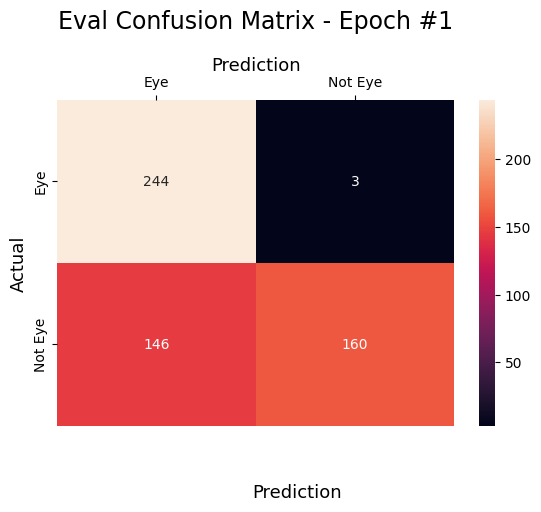

Epoch #2
Training: 
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2338
           1       0.93      0.62      0.74      2635

    accuracy                           0.77      4973
   macro avg       0.81      0.78      0.77      4973
weighted avg       0.82      0.77      0.77      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       247
           1       0.93      0.72      0.81       306

    accuracy                           0.81       553
   macro avg       0.83      0.83      0.81       553
weighted avg       0.84      0.81      0.81       553



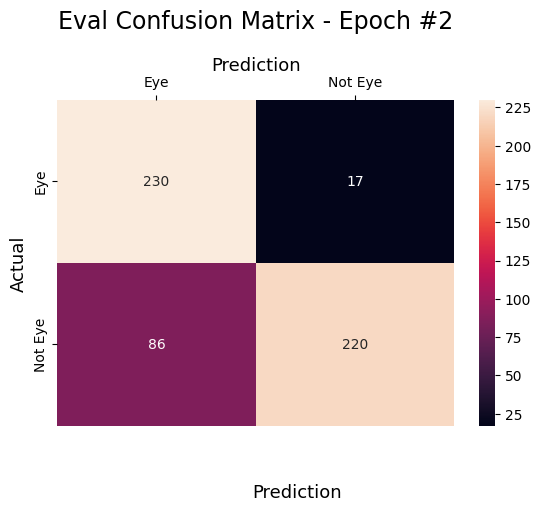

Epoch #3
Training: 
              precision    recall  f1-score   support

           0       0.72      0.94      0.82      2338
           1       0.93      0.68      0.79      2635

    accuracy                           0.80      4973
   macro avg       0.83      0.81      0.80      4973
weighted avg       0.83      0.80      0.80      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       247
           1       0.90      0.77      0.83       306

    accuracy                           0.82       553
   macro avg       0.83      0.83      0.82       553
weighted avg       0.84      0.82      0.82       553



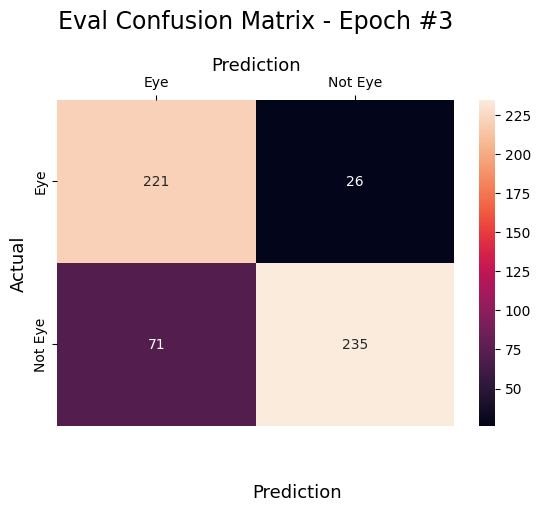

Epoch #4
Training: 
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      2338
           1       0.92      0.67      0.78      2635

    accuracy                           0.79      4973
   macro avg       0.82      0.80      0.79      4973
weighted avg       0.82      0.79      0.79      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       247
           1       0.99      0.37      0.54       306

    accuracy                           0.65       553
   macro avg       0.78      0.68      0.63       553
weighted avg       0.80      0.65      0.62       553



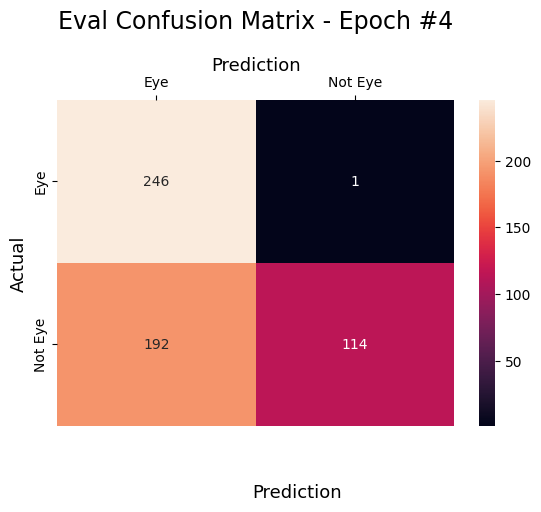

Epoch #5
Training: 
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      2338
           1       0.96      0.62      0.75      2635

    accuracy                           0.78      4973
   macro avg       0.83      0.79      0.78      4973
weighted avg       0.84      0.78      0.78      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.67      0.97      0.79       247
           1       0.96      0.61      0.75       306

    accuracy                           0.77       553
   macro avg       0.82      0.79      0.77       553
weighted avg       0.83      0.77      0.77       553



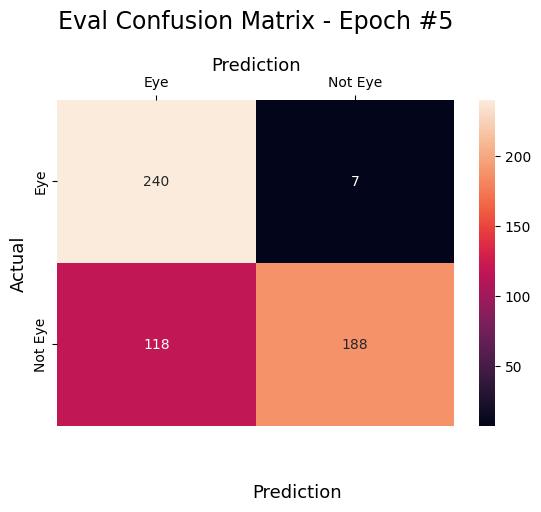

Epoch #6
Training: 
              precision    recall  f1-score   support

           0       0.72      0.94      0.82      2338
           1       0.93      0.68      0.78      2635

    accuracy                           0.80      4973
   macro avg       0.82      0.81      0.80      4973
weighted avg       0.83      0.80      0.80      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       247
           1       0.98      0.60      0.75       306

    accuracy                           0.77       553
   macro avg       0.83      0.79      0.77       553
weighted avg       0.84      0.77      0.77       553



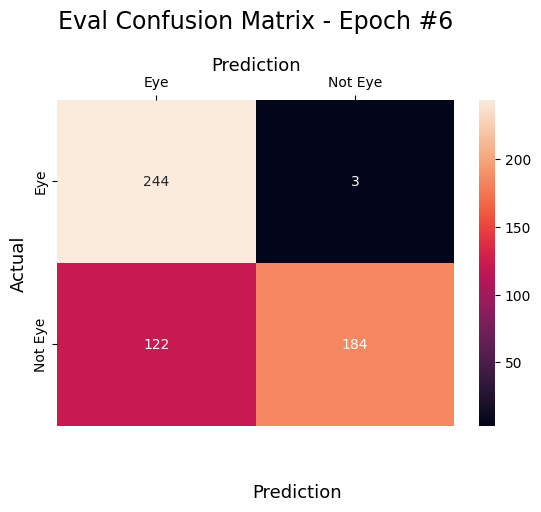

Epoch #7
Training: 
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2338
           1       0.92      0.73      0.82      2635

    accuracy                           0.82      4973
   macro avg       0.84      0.83      0.82      4973
weighted avg       0.84      0.82      0.82      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       247
           1       0.98      0.71      0.83       306

    accuracy                           0.83       553
   macro avg       0.86      0.85      0.83       553
weighted avg       0.87      0.83      0.83       553



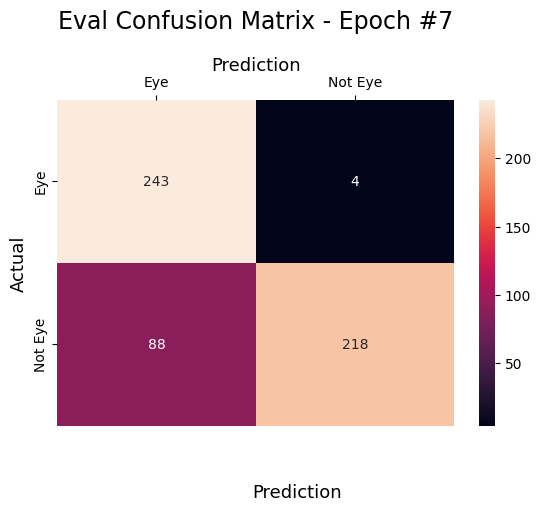

Epoch #8
Training: 
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      2338
           1       0.95      0.76      0.84      2635

    accuracy                           0.85      4973
   macro avg       0.86      0.85      0.85      4973
weighted avg       0.87      0.85      0.85      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       247
           1       0.96      0.70      0.81       306

    accuracy                           0.82       553
   macro avg       0.84      0.83      0.82       553
weighted avg       0.85      0.82      0.81       553



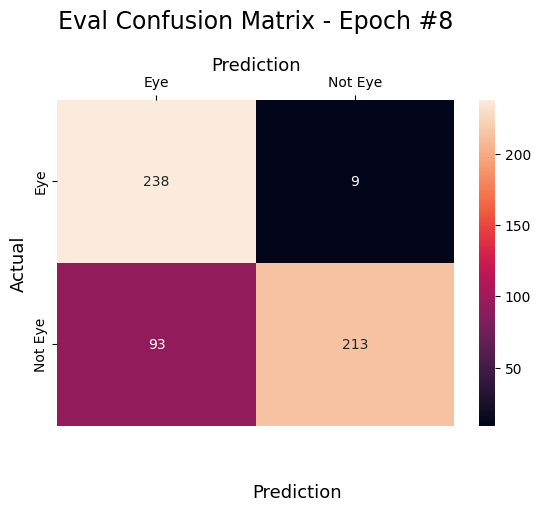

Epoch #9
Training: 
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      2338
           1       0.96      0.72      0.82      2635

    accuracy                           0.84      4973
   macro avg       0.86      0.84      0.84      4973
weighted avg       0.86      0.84      0.83      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       247
           1       0.97      0.79      0.87       306

    accuracy                           0.87       553
   macro avg       0.88      0.88      0.87       553
weighted avg       0.89      0.87      0.87       553



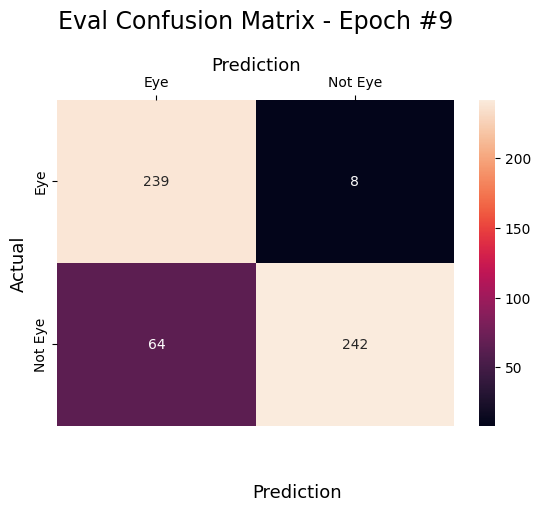

Epoch #10
Training: 
              precision    recall  f1-score   support

           0       0.77      0.96      0.85      2338
           1       0.95      0.75      0.84      2635

    accuracy                           0.84      4973
   macro avg       0.86      0.85      0.84      4973
weighted avg       0.87      0.84      0.84      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       247
           1       0.96      0.74      0.84       306

    accuracy                           0.84       553
   macro avg       0.86      0.85      0.84       553
weighted avg       0.87      0.84      0.84       553



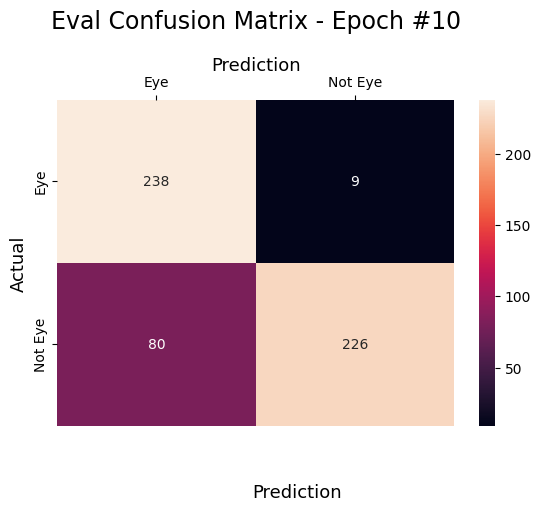

Epoch #11
Training: 
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      2338
           1       0.94      0.76      0.84      2635

    accuracy                           0.84      4973
   macro avg       0.86      0.85      0.84      4973
weighted avg       0.86      0.84      0.84      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       247
           1       0.97      0.74      0.84       306

    accuracy                           0.84       553
   macro avg       0.86      0.85      0.84       553
weighted avg       0.87      0.84      0.84       553



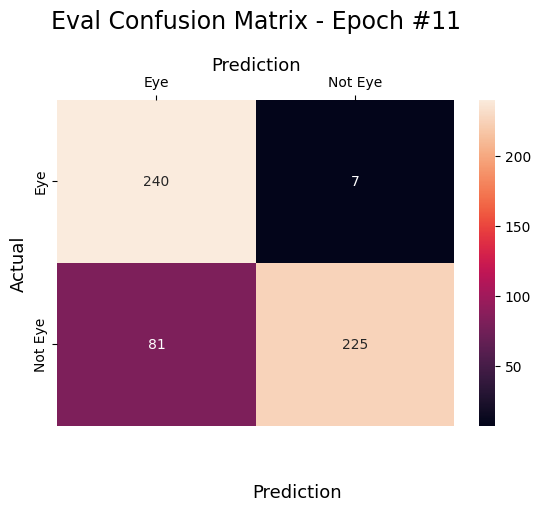

Epoch #12
Training: 
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      2338
           1       0.95      0.76      0.84      2635

    accuracy                           0.85      4973
   macro avg       0.86      0.86      0.85      4973
weighted avg       0.87      0.85      0.85      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.74      0.97      0.84       247
           1       0.97      0.72      0.83       306

    accuracy                           0.83       553
   macro avg       0.85      0.85      0.83       553
weighted avg       0.87      0.83      0.83       553



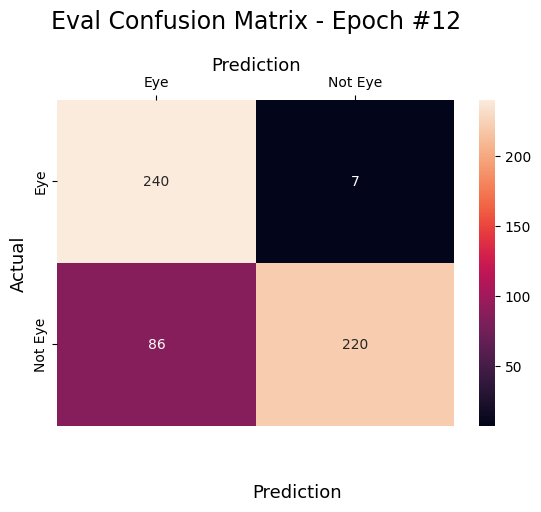

Epoch #13
Training: 
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      2338
           1       0.95      0.74      0.83      2635

    accuracy                           0.84      4973
   macro avg       0.86      0.85      0.84      4973
weighted avg       0.86      0.84      0.84      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       247
           1       0.96      0.77      0.86       306

    accuracy                           0.86       553
   macro avg       0.87      0.87      0.86       553
weighted avg       0.88      0.86      0.86       553



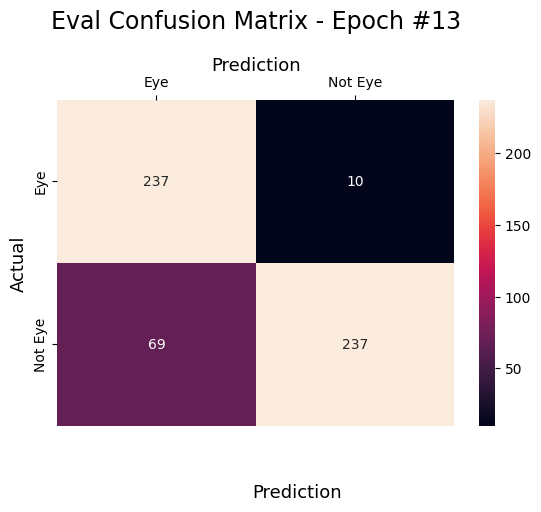

Epoch #14
Training: 
              precision    recall  f1-score   support

           0       0.75      0.97      0.85      2338
           1       0.97      0.72      0.82      2635

    accuracy                           0.84      4973
   macro avg       0.86      0.85      0.84      4973
weighted avg       0.87      0.84      0.84      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       247
           1       0.98      0.79      0.87       306

    accuracy                           0.87       553
   macro avg       0.88      0.88      0.87       553
weighted avg       0.89      0.87      0.87       553



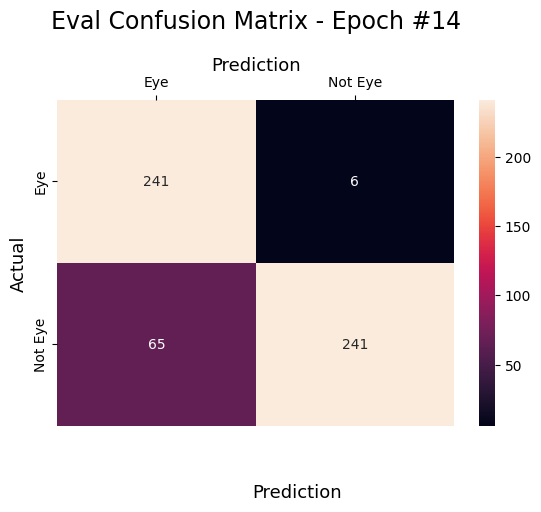

Epoch #15
Training: 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2338
           1       0.92      0.82      0.87      2635

    accuracy                           0.87      4973
   macro avg       0.87      0.87      0.87      4973
weighted avg       0.88      0.87      0.87      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       247
           1       0.94      0.85      0.89       306

    accuracy                           0.88       553
   macro avg       0.88      0.89      0.88       553
weighted avg       0.89      0.88      0.88       553



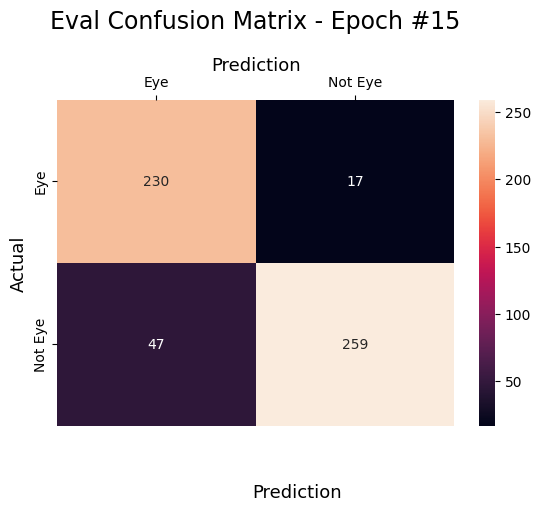

Epoch #16
Training: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2338
           1       0.91      0.86      0.89      2635

    accuracy                           0.88      4973
   macro avg       0.88      0.88      0.88      4973
weighted avg       0.88      0.88      0.88      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       247
           1       0.94      0.72      0.81       306

    accuracy                           0.82       553
   macro avg       0.83      0.83      0.82       553
weighted avg       0.84      0.82      0.81       553



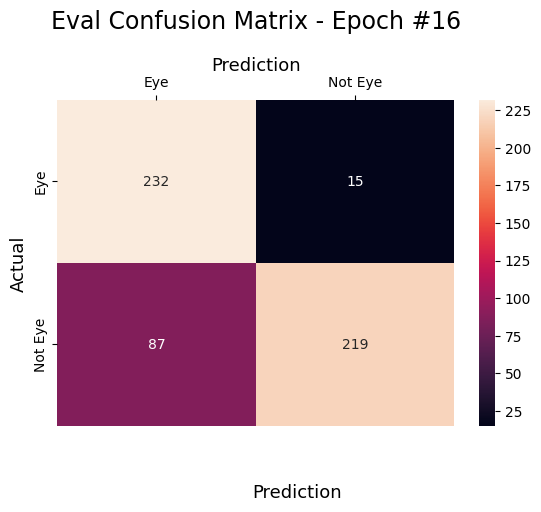

Epoch #17
Training: 
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2338
           1       0.95      0.81      0.87      2635

    accuracy                           0.88      4973
   macro avg       0.88      0.88      0.88      4973
weighted avg       0.89      0.88      0.88      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       247
           1       0.98      0.79      0.88       306

    accuracy                           0.88       553
   macro avg       0.89      0.89      0.88       553
weighted avg       0.90      0.88      0.88       553



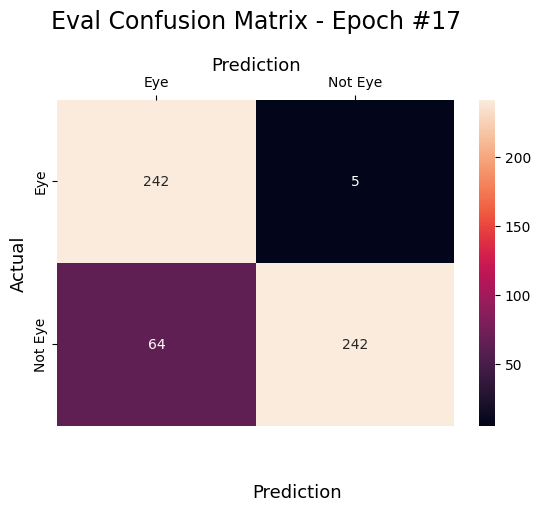

Epoch #18
Training: 
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2338
           1       0.95      0.79      0.86      2635

    accuracy                           0.87      4973
   macro avg       0.88      0.87      0.87      4973
weighted avg       0.88      0.87      0.87      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       247
           1       0.96      0.76      0.85       306

    accuracy                           0.85       553
   macro avg       0.86      0.86      0.85       553
weighted avg       0.87      0.85      0.85       553



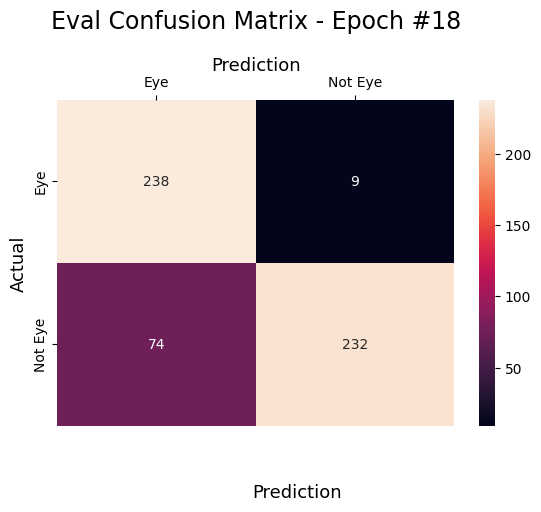

Epoch #19
Training: 
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      2338
           1       0.92      0.70      0.80      2635

    accuracy                           0.81      4973
   macro avg       0.83      0.82      0.81      4973
weighted avg       0.83      0.81      0.81      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       247
           1       0.92      0.85      0.88       306

    accuracy                           0.87       553
   macro avg       0.87      0.88      0.87       553
weighted avg       0.88      0.87      0.87       553



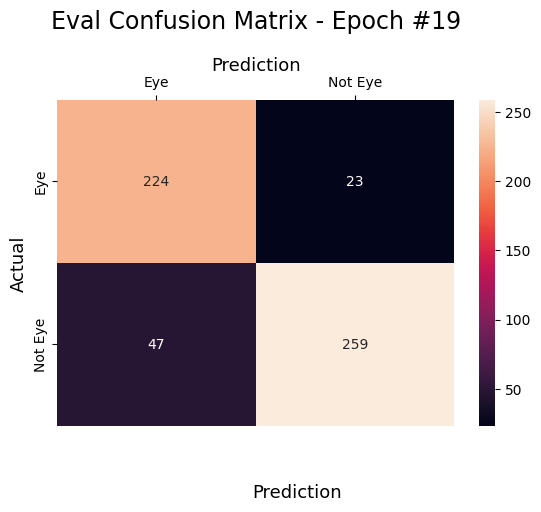

Epoch #20
Training: 
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2338
           1       0.94      0.78      0.85      2635

    accuracy                           0.86      4973
   macro avg       0.87      0.86      0.86      4973
weighted avg       0.87      0.86      0.86      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       247
           1       0.97      0.84      0.90       306

    accuracy                           0.90       553
   macro avg       0.90      0.90      0.89       553
weighted avg       0.91      0.90      0.90       553



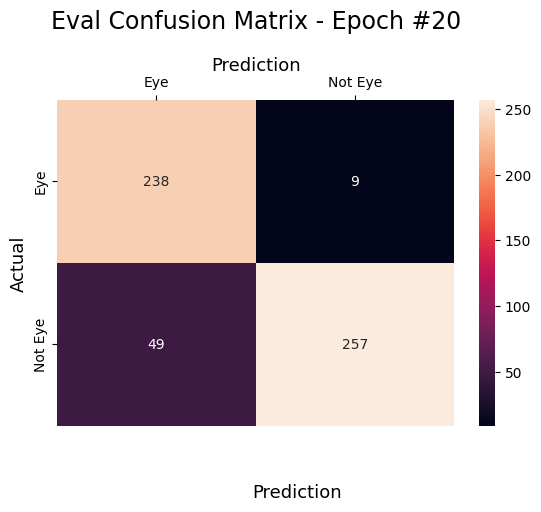

Epoch #21
Training: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2338
           1       0.96      0.82      0.88      2635

    accuracy                           0.89      4973
   macro avg       0.89      0.89      0.89      4973
weighted avg       0.90      0.89      0.89      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.97      0.88      0.92       306

    accuracy                           0.92       553
   macro avg       0.91      0.92      0.91       553
weighted avg       0.92      0.92      0.92       553



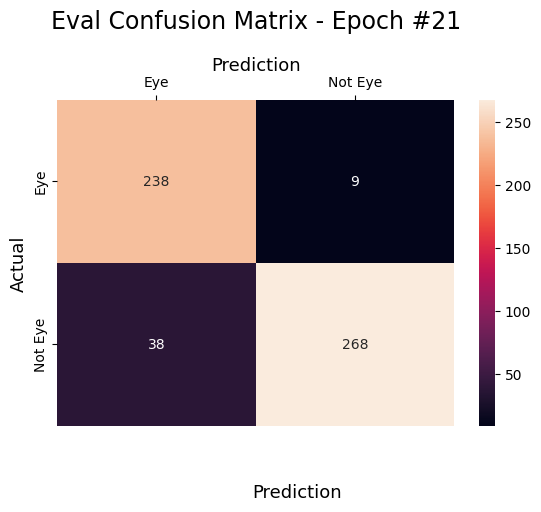

Epoch #22
Training: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2338
           1       0.95      0.88      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.91      0.91      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.69      0.99      0.82       247
           1       0.99      0.65      0.78       306

    accuracy                           0.80       553
   macro avg       0.84      0.82      0.80       553
weighted avg       0.86      0.80      0.80       553



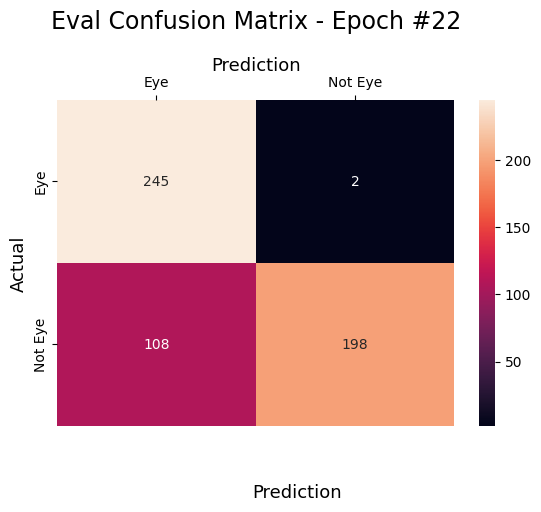

Epoch #23
Training: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.88      2338
           1       0.95      0.83      0.88      2635

    accuracy                           0.88      4973
   macro avg       0.89      0.89      0.88      4973
weighted avg       0.89      0.88      0.88      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       247
           1       0.94      0.88      0.91       306

    accuracy                           0.90       553
   macro avg       0.90      0.91      0.90       553
weighted avg       0.91      0.90      0.90       553



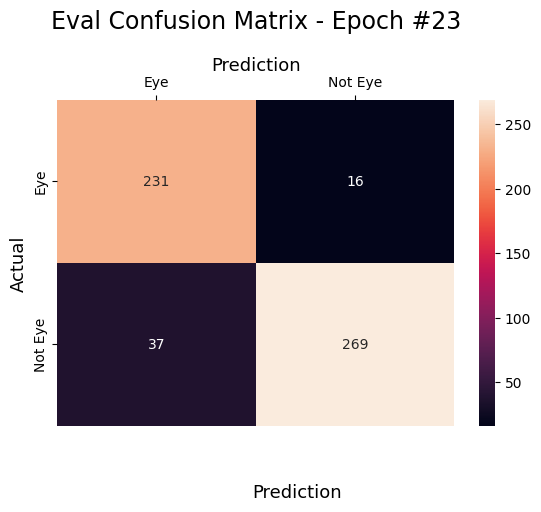

Epoch #24
Training: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2338
           1       0.95      0.88      0.92      2635

    accuracy                           0.91      4973
   macro avg       0.92      0.92      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       247
           1       0.95      0.91      0.93       306

    accuracy                           0.92       553
   macro avg       0.92      0.93      0.92       553
weighted avg       0.93      0.92      0.92       553



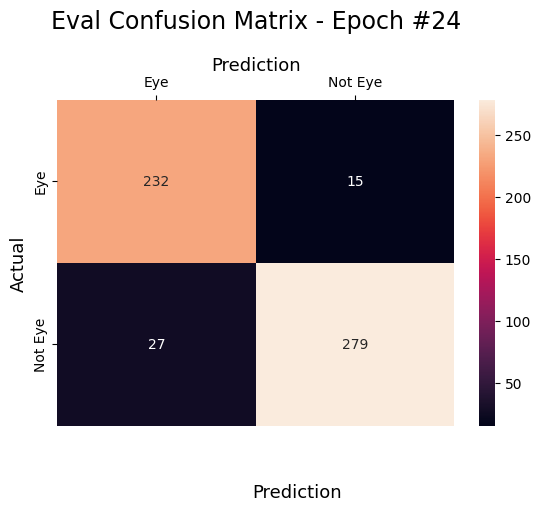

Epoch #25
Training: 
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2338
           1       0.96      0.85      0.90      2635

    accuracy                           0.90      4973
   macro avg       0.91      0.91      0.90      4973
weighted avg       0.91      0.90      0.90      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       247
           1       0.96      0.91      0.93       306

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553



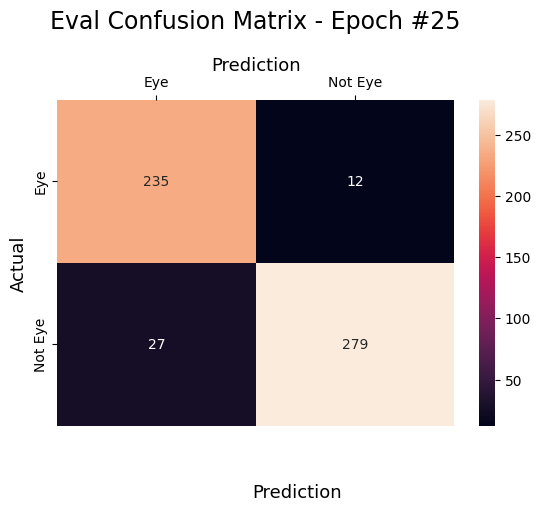

Epoch #26
Training: 
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2338
           1       0.95      0.88      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.91      0.91      0.91      4973
weighted avg       0.91      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       247
           1       0.96      0.84      0.90       306

    accuracy                           0.89       553
   macro avg       0.89      0.90      0.89       553
weighted avg       0.90      0.89      0.89       553



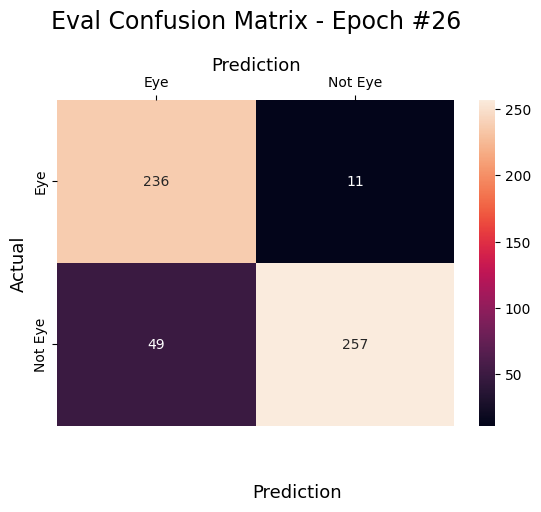

Epoch #27
Training: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      2338
           1       0.96      0.84      0.90      2635

    accuracy                           0.90      4973
   macro avg       0.90      0.90      0.90      4973
weighted avg       0.90      0.90      0.90      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       247
           1       0.98      0.84      0.90       306

    accuracy                           0.90       553
   macro avg       0.90      0.91      0.90       553
weighted avg       0.91      0.90      0.90       553



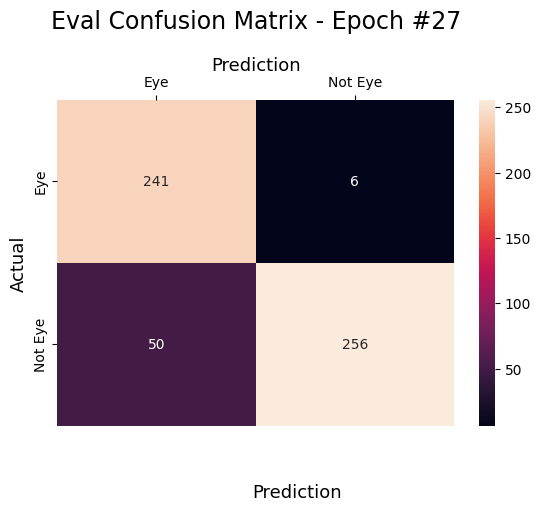

Epoch #28
Training: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2338
           1       0.93      0.88      0.91      2635

    accuracy                           0.90      4973
   macro avg       0.90      0.91      0.90      4973
weighted avg       0.91      0.90      0.90      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       247
           1       0.93      0.80      0.86       306

    accuracy                           0.86       553
   macro avg       0.86      0.86      0.86       553
weighted avg       0.87      0.86      0.86       553



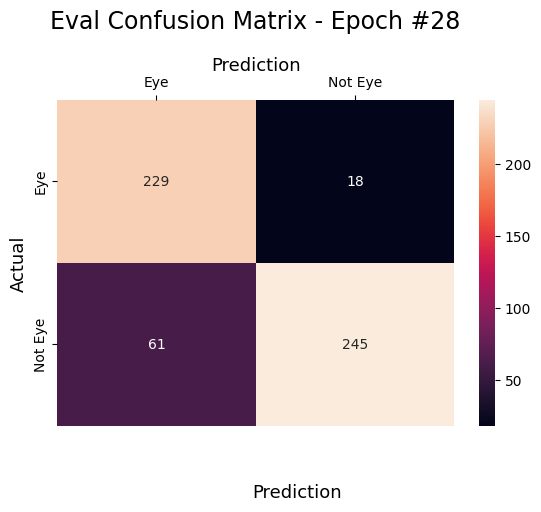

Epoch #29
Training: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      2338
           1       0.95      0.85      0.89      2635

    accuracy                           0.89      4973
   macro avg       0.90      0.90      0.89      4973
weighted avg       0.90      0.89      0.89      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       247
           1       0.98      0.81      0.89       306

    accuracy                           0.88       553
   macro avg       0.89      0.89      0.88       553
weighted avg       0.90      0.88      0.88       553



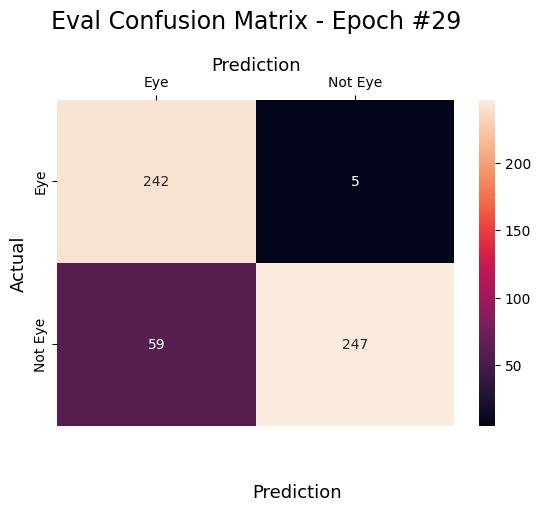

Epoch #30
Training: 
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      2338
           1       0.97      0.79      0.87      2635

    accuracy                           0.87      4973
   macro avg       0.89      0.88      0.87      4973
weighted avg       0.89      0.87      0.87      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       247
           1       0.95      0.91      0.93       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.92      0.92      0.92       553



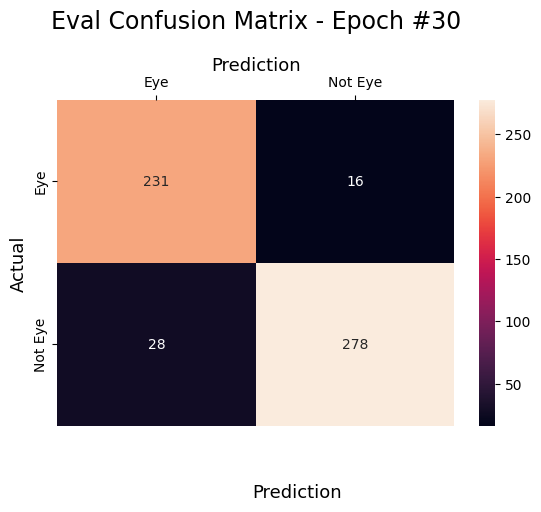

Epoch #31
Training: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2338
           1       0.94      0.89      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.91      0.91      0.91      4973
weighted avg       0.91      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.97      0.88      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.93      0.92      0.92       553



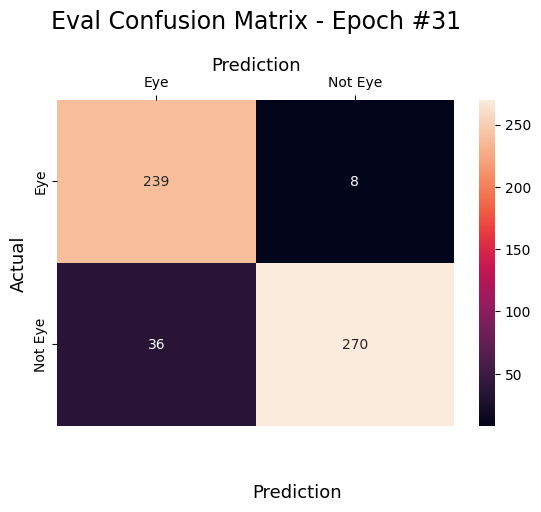

Epoch #32
Training: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2338
           1       0.97      0.87      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.92      0.92      0.92      4973
weighted avg       0.92      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       247
           1       0.97      0.89      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.92      0.92      0.92       553



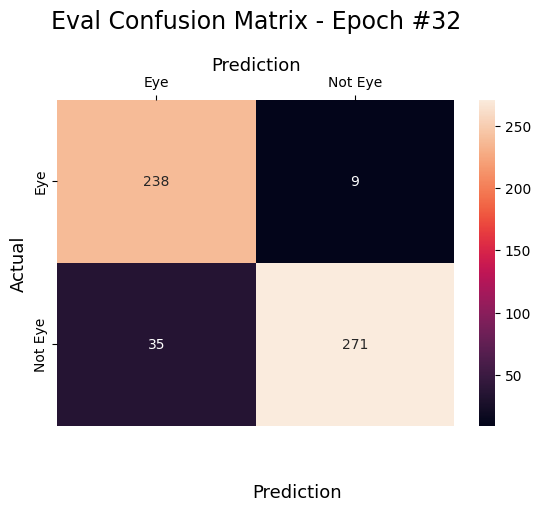

Epoch #33
Training: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2338
           1       0.95      0.85      0.90      2635

    accuracy                           0.90      4973
   macro avg       0.90      0.90      0.90      4973
weighted avg       0.90      0.90      0.90      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       247
           1       0.97      0.86      0.91       306

    accuracy                           0.91       553
   macro avg       0.91      0.92      0.91       553
weighted avg       0.92      0.91      0.91       553



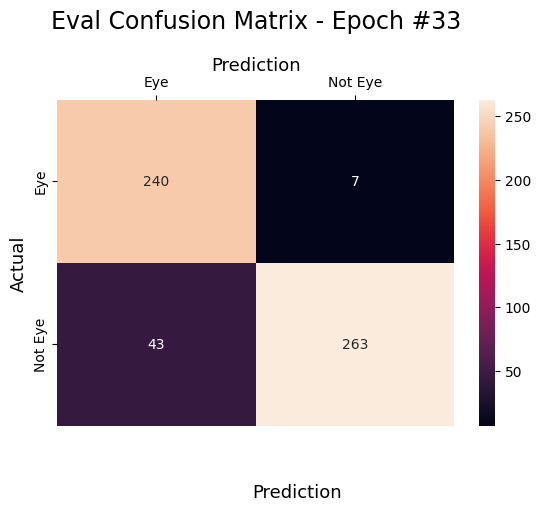

Epoch #34
Training: 
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2338
           1       0.97      0.86      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.91      0.91      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       247
           1       0.98      0.87      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.92      0.92      0.92       553



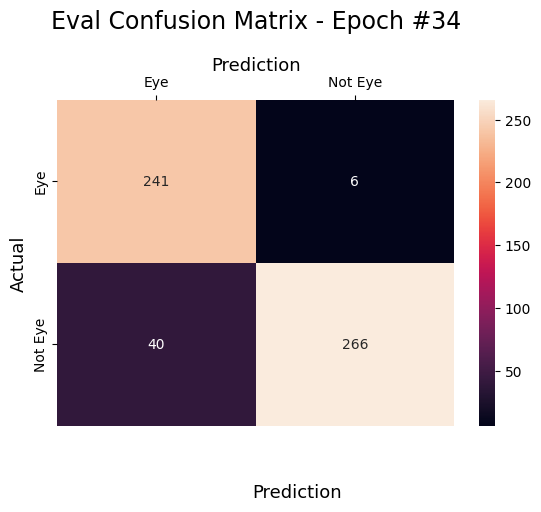

Epoch #35
Training: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2338
           1       0.98      0.85      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.92      0.92      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.98      0.91      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



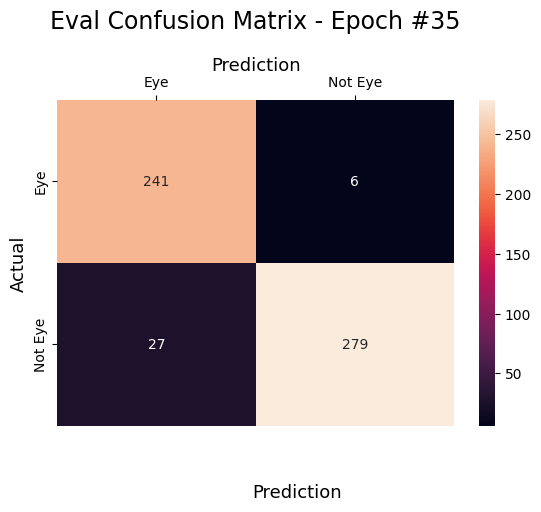

Epoch #36
Training: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2338
           1       0.98      0.86      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.92      0.92      0.92      4973
weighted avg       0.93      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.97      0.88      0.93       306

    accuracy                           0.92       553
   macro avg       0.92      0.93      0.92       553
weighted avg       0.93      0.92      0.92       553



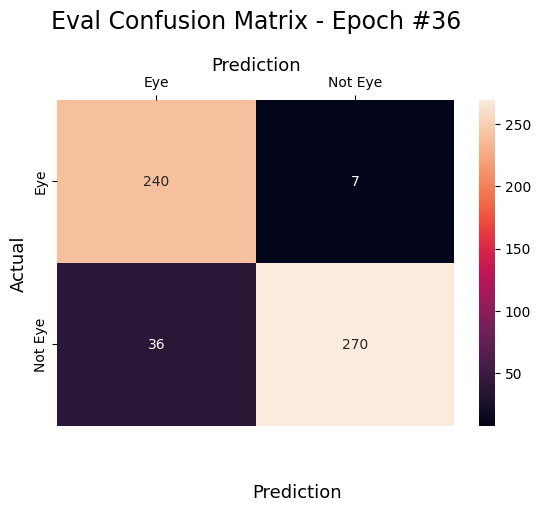

Epoch #37
Training: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2338
           1       0.96      0.91      0.94      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       247
           1       0.97      0.93      0.95       306

    accuracy                           0.95       553
   macro avg       0.94      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



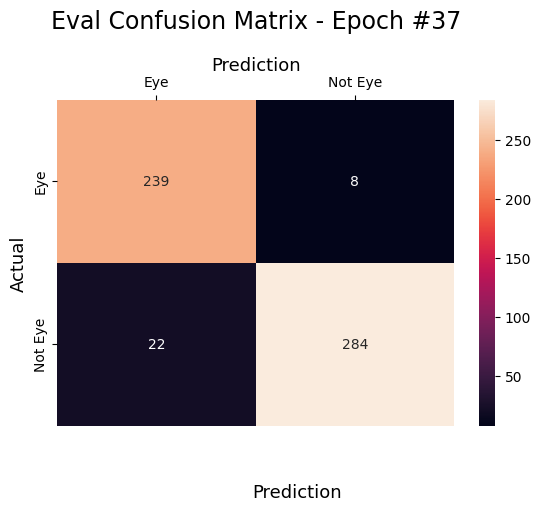

Epoch #38
Training: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2338
           1       0.97      0.91      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       247
           1       0.98      0.94      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



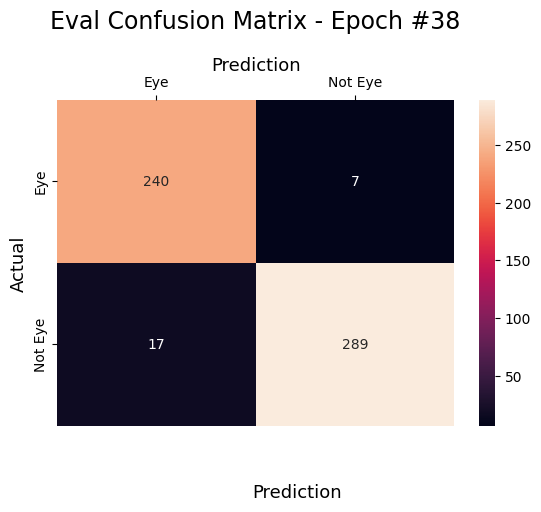

Epoch #39
Training: 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2338
           1       0.96      0.91      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.96      0.88      0.92       306

    accuracy                           0.91       553
   macro avg       0.91      0.92      0.91       553
weighted avg       0.92      0.91      0.91       553



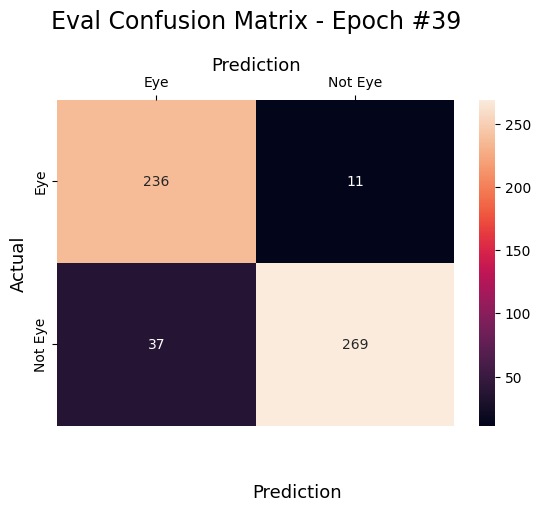

Epoch #40
Training: 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2338
           1       0.97      0.84      0.90      2635

    accuracy                           0.90      4973
   macro avg       0.90      0.90      0.90      4973
weighted avg       0.91      0.90      0.90      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       247
           1       0.99      0.80      0.88       306

    accuracy                           0.88       553
   macro avg       0.89      0.89      0.88       553
weighted avg       0.90      0.88      0.88       553



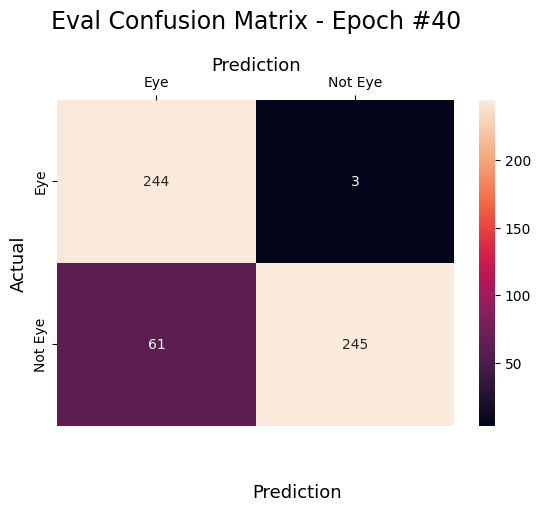

Epoch #41
Training: 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2338
           1       0.97      0.90      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       247
           1       0.96      0.93      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



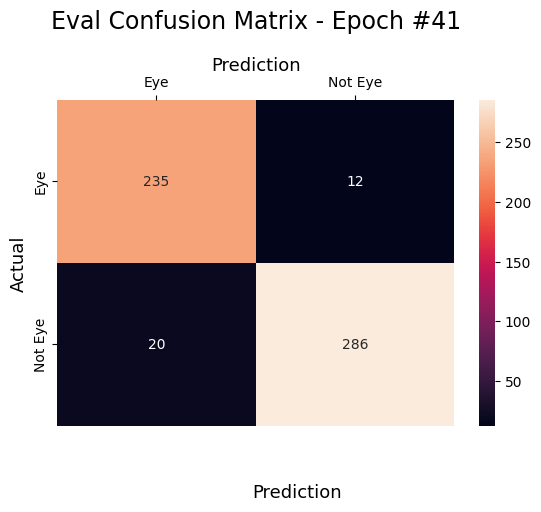

Epoch #42
Training: 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2338
           1       0.97      0.90      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       247
           1       0.97      0.92      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



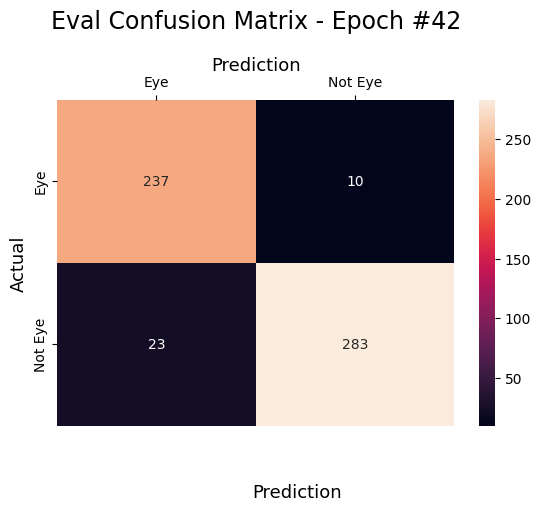

Epoch #43
Training: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2338
           1       0.92      0.92      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.92      0.92      0.92      4973
weighted avg       0.92      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.81      0.98      0.88       247
           1       0.98      0.81      0.89       306

    accuracy                           0.89       553
   macro avg       0.89      0.90      0.89       553
weighted avg       0.90      0.89      0.89       553



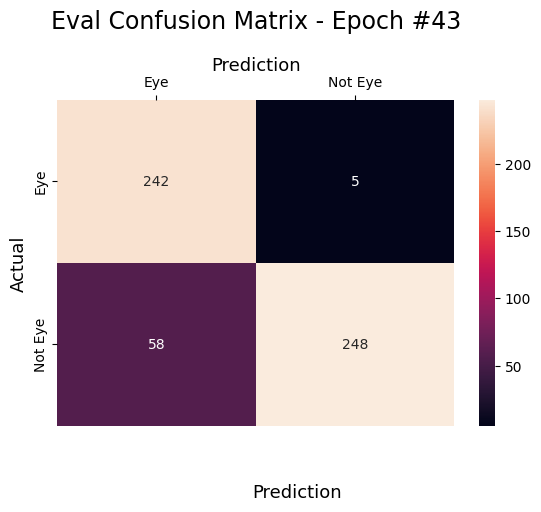

Epoch #44
Training: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2338
           1       0.98      0.86      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.92      0.92      0.92      4973
weighted avg       0.93      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       247
           1       0.98      0.93      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



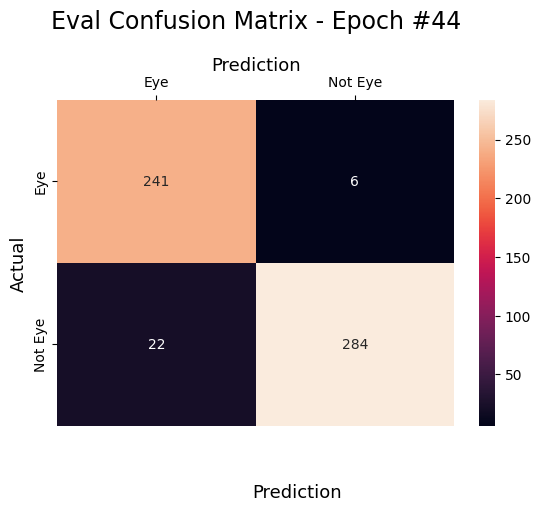

Epoch #45
Training: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2338
           1       0.97      0.92      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       247
           1       0.98      0.91      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



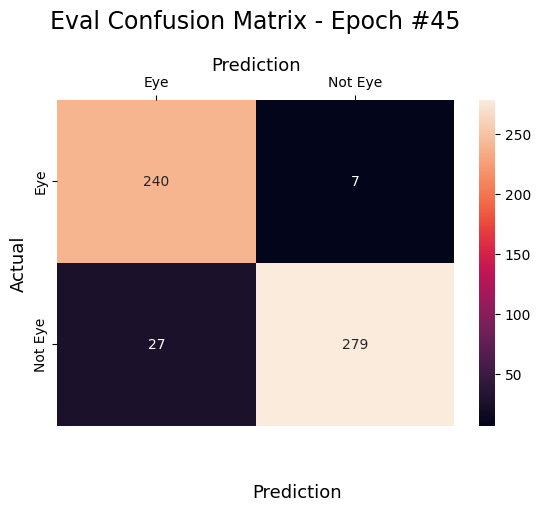

Epoch #46
Training: 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2338
           1       0.96      0.91      0.94      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.94      0.93      4973
weighted avg       0.94      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       247
           1       0.97      0.93      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.94      0.94      0.94       553



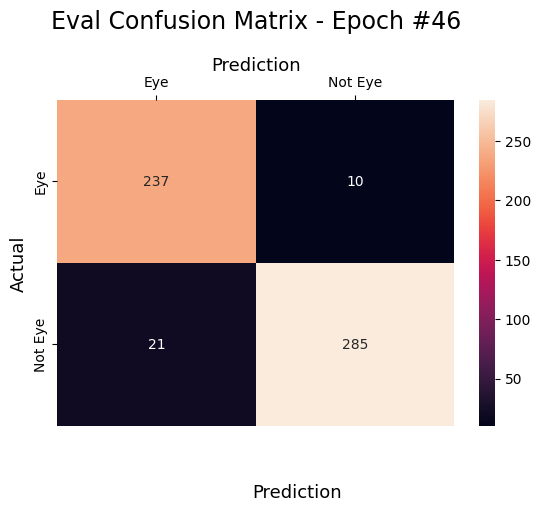

Epoch #47
Training: 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2338
           1       0.97      0.93      0.95      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.99      0.89      0.94       306

    accuracy                           0.93       553
   macro avg       0.93      0.94      0.93       553
weighted avg       0.94      0.93      0.93       553



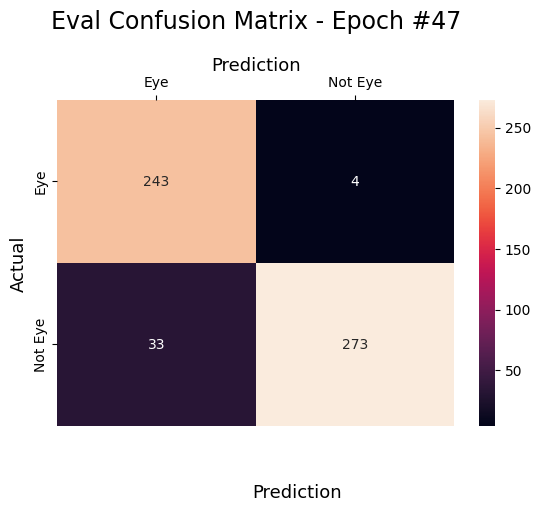

Epoch #48
Training: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2338
           1       0.99      0.87      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       247
           1       0.99      0.86      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.93      0.92       553
weighted avg       0.93      0.92      0.92       553



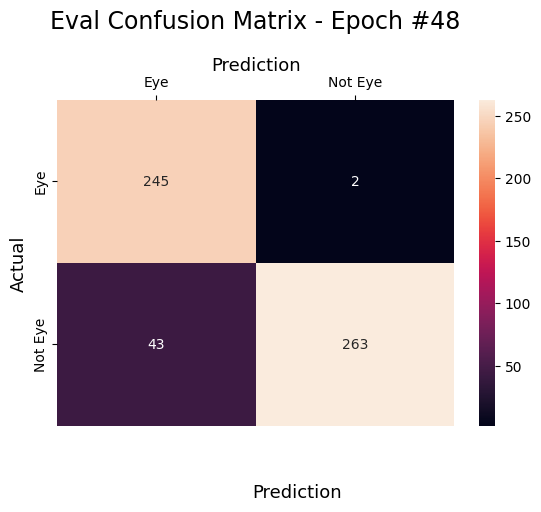

Epoch #49
Training: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2338
           1       0.99      0.89      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       247
           1       0.99      0.83      0.91       306

    accuracy                           0.90       553
   macro avg       0.91      0.91      0.90       553
weighted avg       0.92      0.90      0.90       553



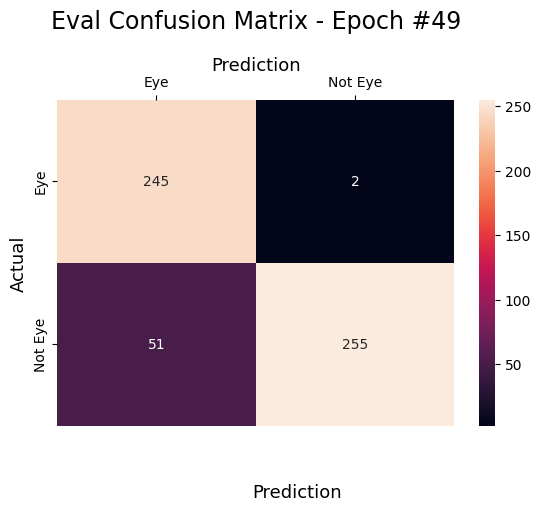

Epoch #50
Training: 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2338
           1       0.99      0.84      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.92      0.92      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       247
           1       0.99      0.89      0.94       306

    accuracy                           0.93       553
   macro avg       0.93      0.94      0.93       553
weighted avg       0.94      0.93      0.93       553



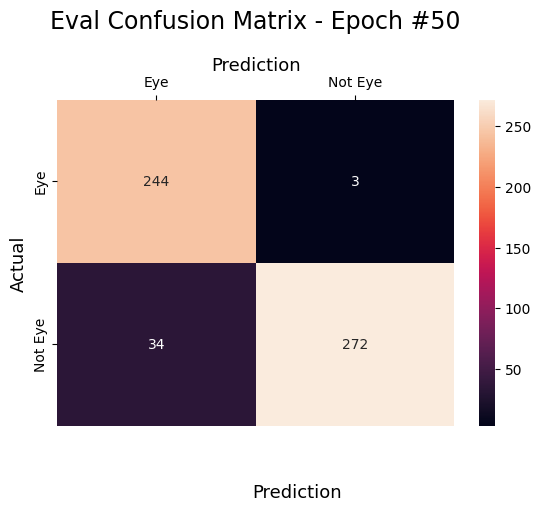

Epoch #51
Training: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2338
           1       0.98      0.89      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       247
           1       0.99      0.92      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



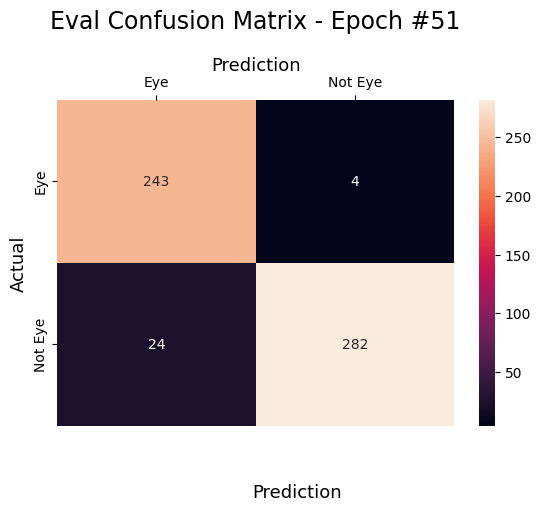

Epoch #52
Training: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2338
           1       0.99      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.95      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       247
           1       0.99      0.82      0.90       306

    accuracy                           0.90       553
   macro avg       0.91      0.91      0.90       553
weighted avg       0.91      0.90      0.90       553



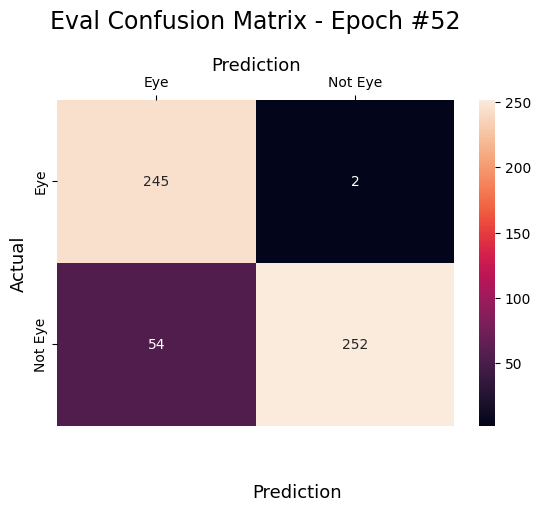

Epoch #53
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2338
           1       0.98      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       247
           1       0.99      0.88      0.93       306

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553



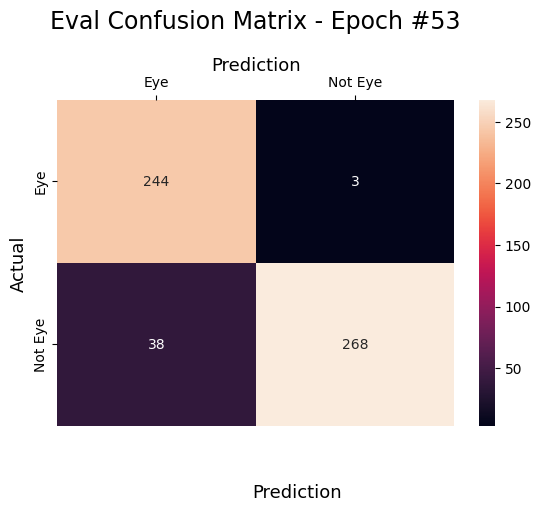

Epoch #54
Training: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2338
           1       0.99      0.88      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.94      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       247
           1       0.99      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



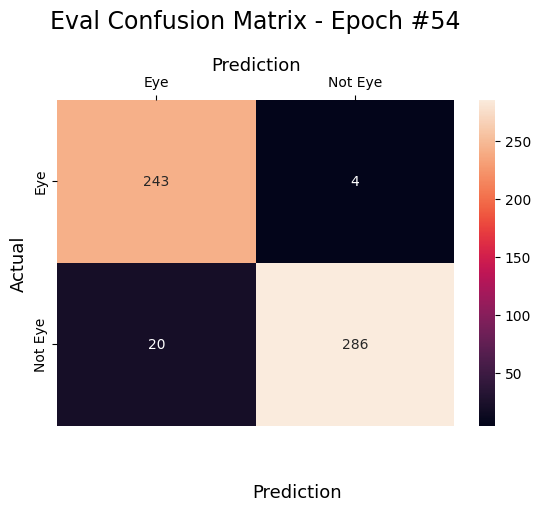

Epoch #55
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2338
           1       0.98      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.98      0.91      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



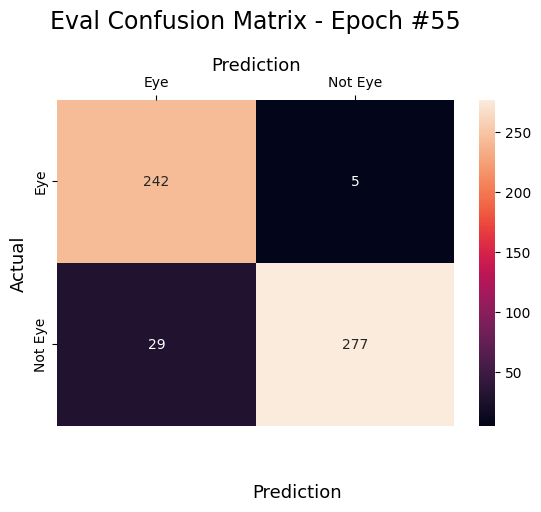

Epoch #56
Training: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2338
           1       0.98      0.88      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.78      0.99      0.87       247
           1       0.99      0.77      0.87       306

    accuracy                           0.87       553
   macro avg       0.89      0.88      0.87       553
weighted avg       0.90      0.87      0.87       553



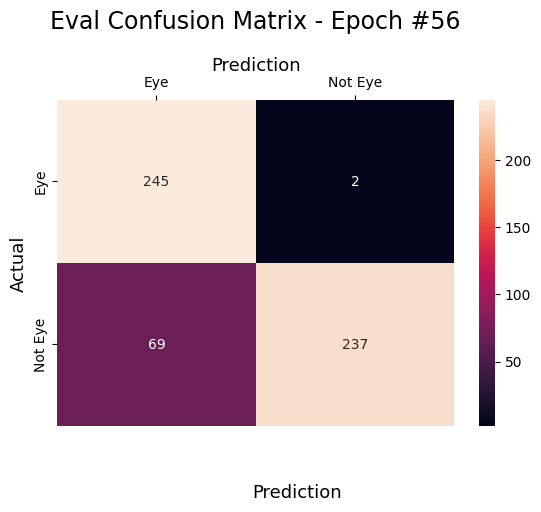

Epoch #57
Training: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2338
           1       0.98      0.88      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.94      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       247
           1       0.98      0.92      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



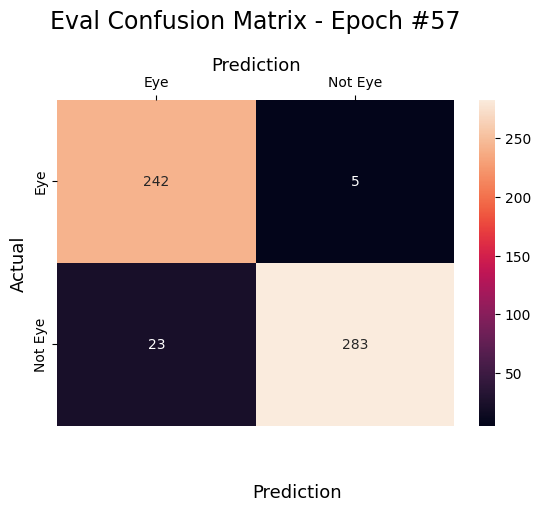

Epoch #58
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2338
           1       0.98      0.91      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.98      0.91      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



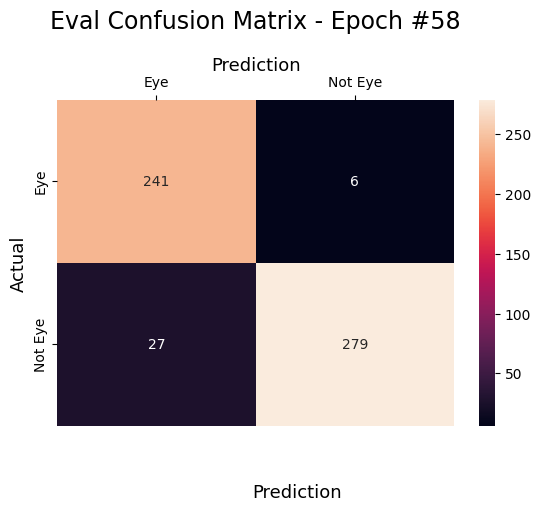

Epoch #59
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2338
           1       0.98      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.98      0.91      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



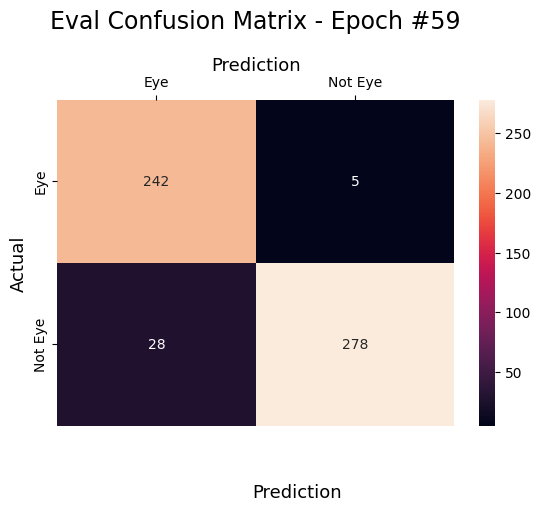

Epoch #60
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.94      2338
           1       0.98      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.98      0.92      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.94      0.94      0.94       553



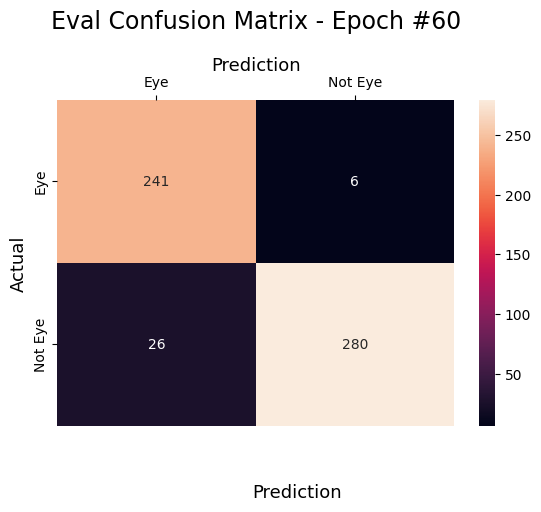

Epoch #61
Training: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2338
           1       0.97      0.92      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       247
           1       0.98      0.89      0.93       306

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553



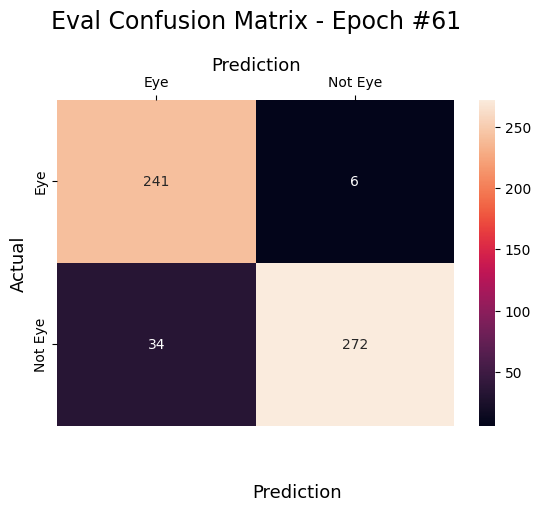

Epoch #62
Training: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2338
           1       0.98      0.89      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.94      0.94      0.93      4973
weighted avg       0.94      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.98      0.88      0.93       306

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553



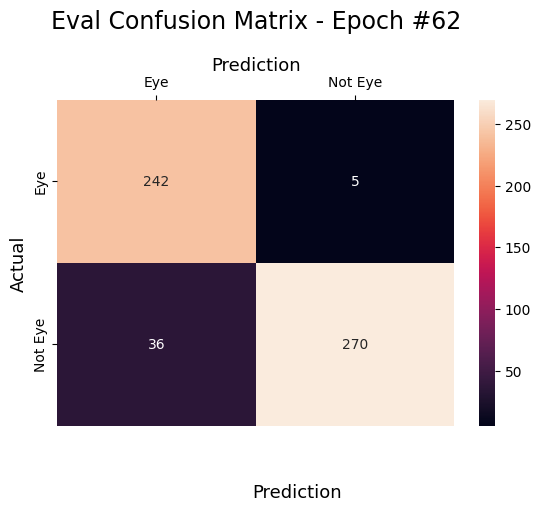

Epoch #63
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2338
           1       0.98      0.91      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.98      0.92      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.95      0.94      0.94       553



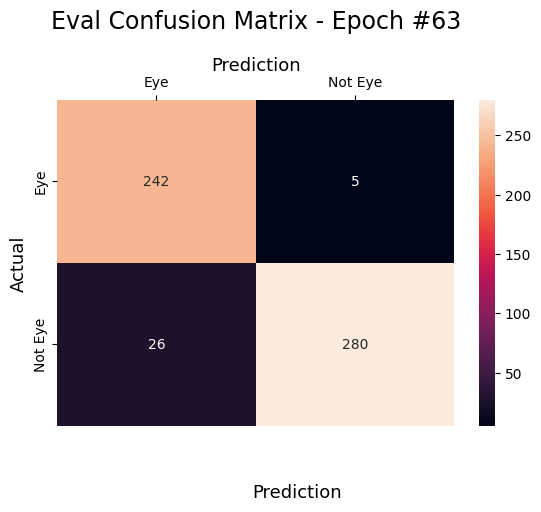

Epoch #64
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2338
           1       0.98      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.97      0.96      0.96       553



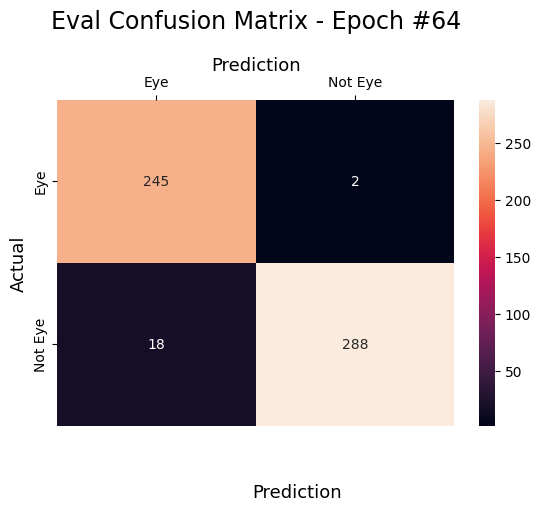

Epoch #65
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2338
           1       0.99      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       247
           1       0.99      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



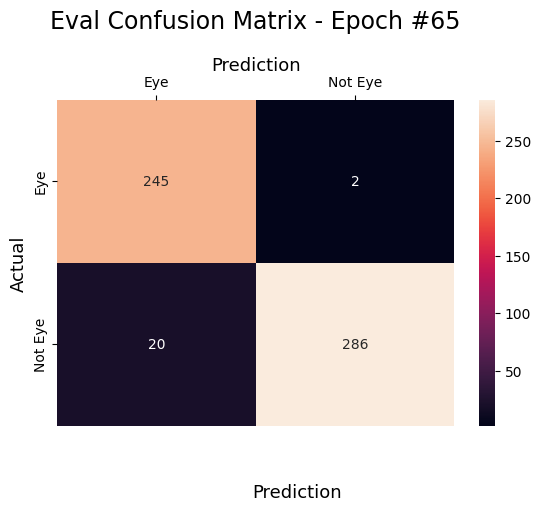

Epoch #66
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2338
           1       0.98      0.93      0.96      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.99      0.86      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.92       553
weighted avg       0.93      0.92      0.92       553



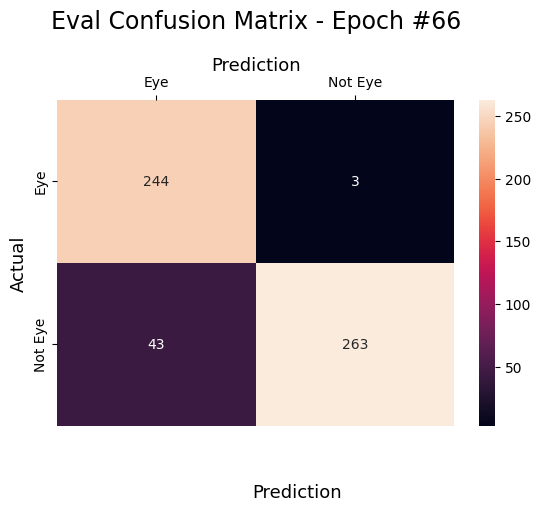

Epoch #67
Training: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2338
           1       0.99      0.89      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       247
           1       1.00      0.71      0.83       306

    accuracy                           0.84       553
   macro avg       0.86      0.85      0.83       553
weighted avg       0.88      0.84      0.83       553



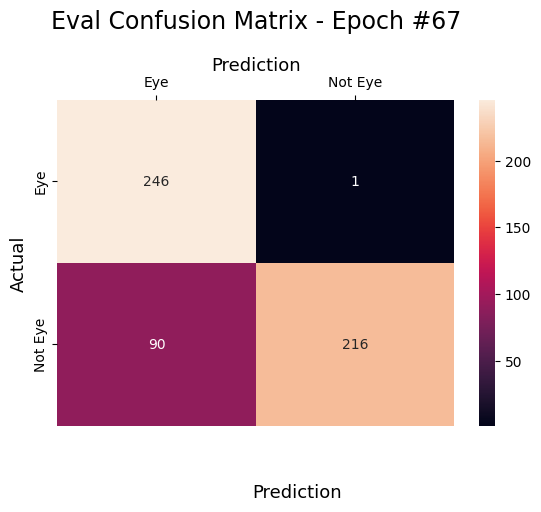

Epoch #68
Training: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2338
           1       0.99      0.87      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.93      0.93      0.92      4973
weighted avg       0.93      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       247
           1       1.00      0.88      0.94       306

    accuracy                           0.93       553
   macro avg       0.93      0.94      0.93       553
weighted avg       0.94      0.93      0.93       553



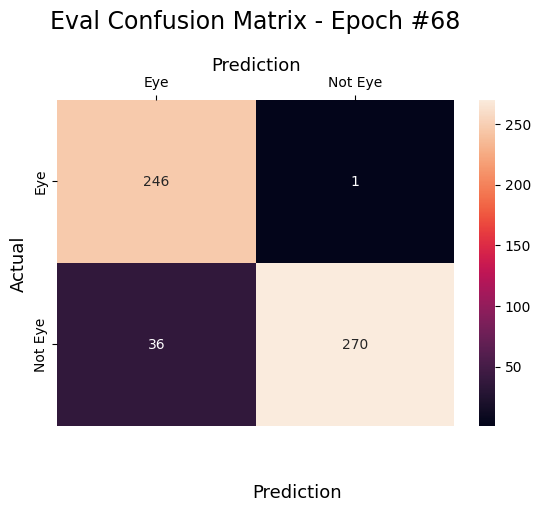

Epoch #69
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2338
           1       0.98      0.93      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       247
           1       0.99      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



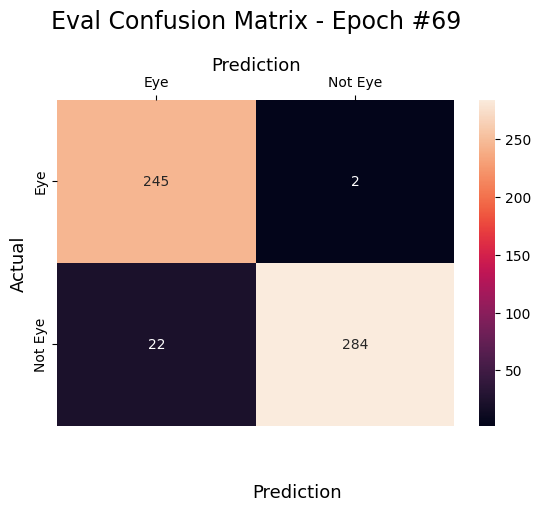

Epoch #70
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



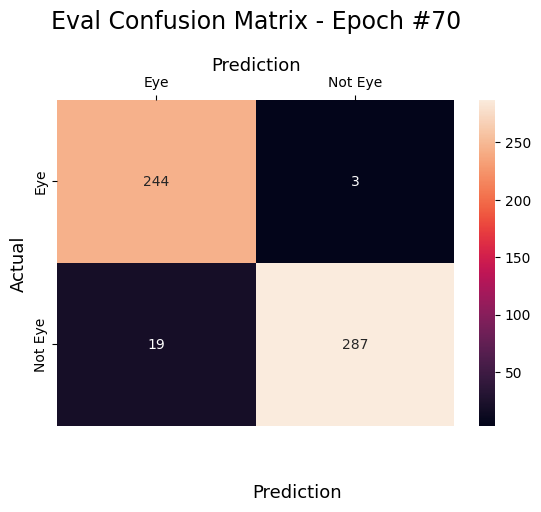

Epoch #71
Training: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2338
           1       0.95      0.94      0.95      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       247
           1       0.96      0.93      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



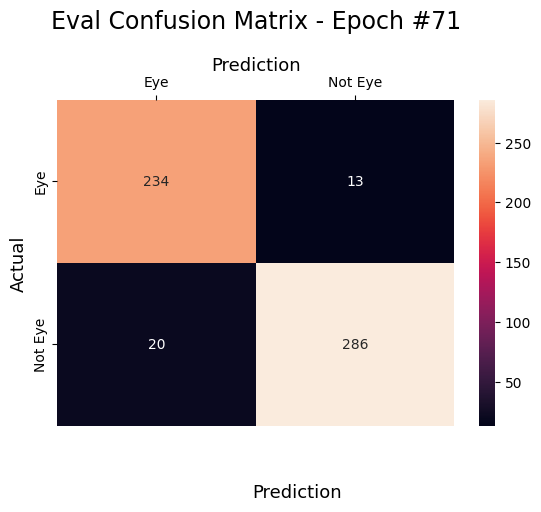

Epoch #72
Training: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2338
           1       0.97      0.94      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       247
           1       0.97      0.93      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



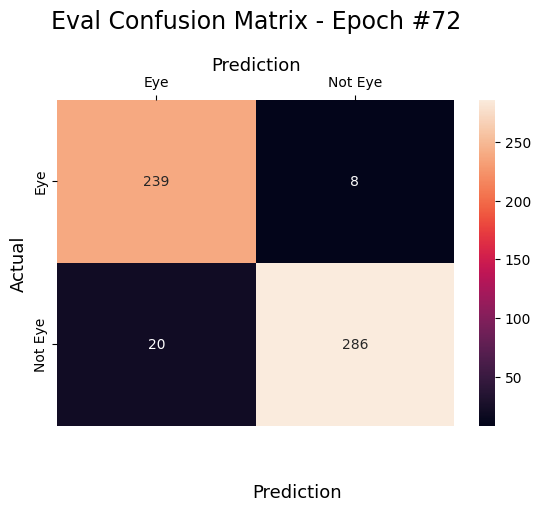

Epoch #73
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2338
           1       0.98      0.91      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       247
           1       0.99      0.92      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



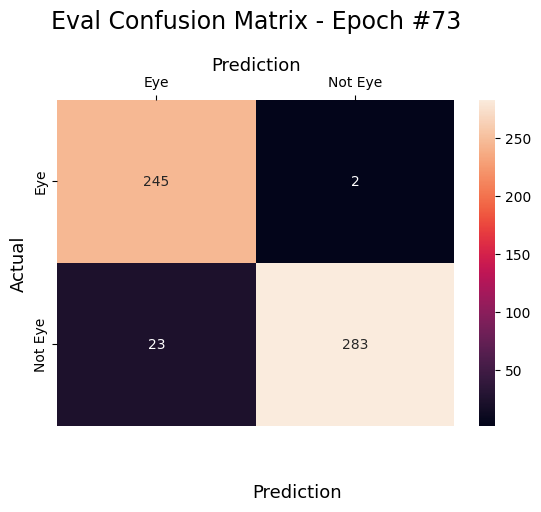

Epoch #74
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2338
           1       0.98      0.93      0.96      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.96      0.95      4973
weighted avg       0.96      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       247
           1       0.99      0.91      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.95      0.94      0.94       553



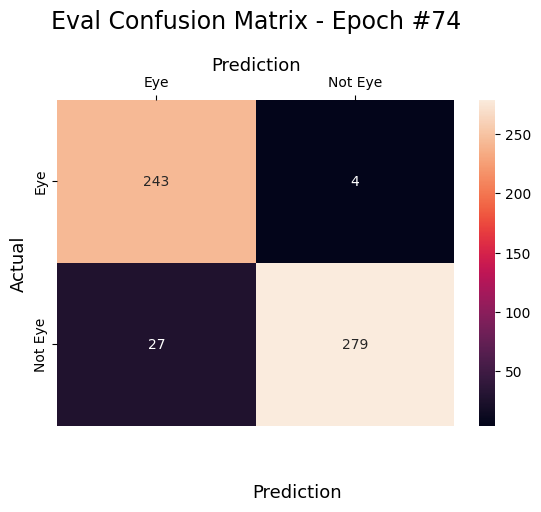

Epoch #75
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2338
           1       0.98      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       247
           1       0.99      0.90      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.95      0.94      0.94       553



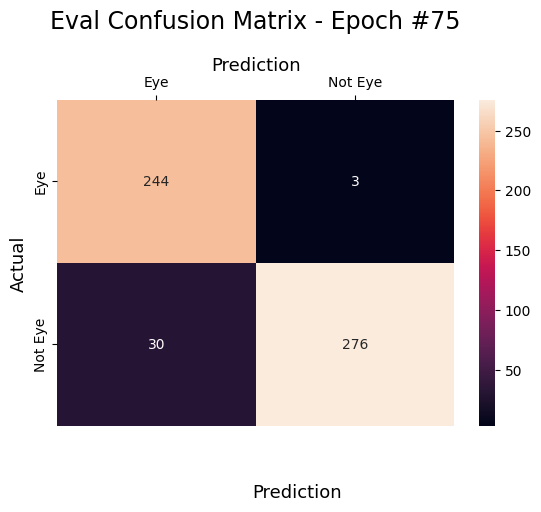

Epoch #76
Training: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2338
           1       0.99      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.95      0.95      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       247
           1       0.99      0.92      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



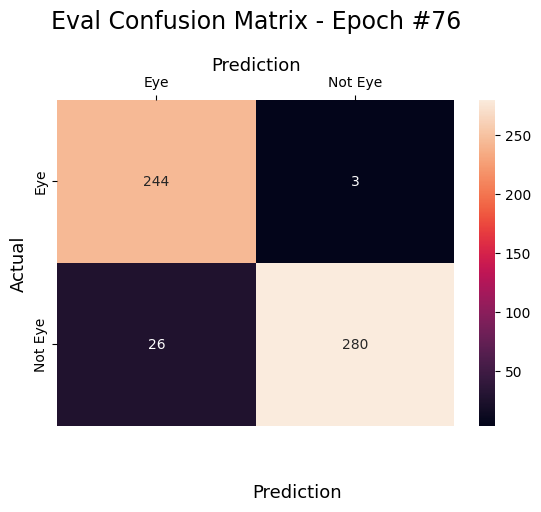

Epoch #77
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       247
           1       0.99      0.87      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.93      0.92       553
weighted avg       0.93      0.92      0.92       553



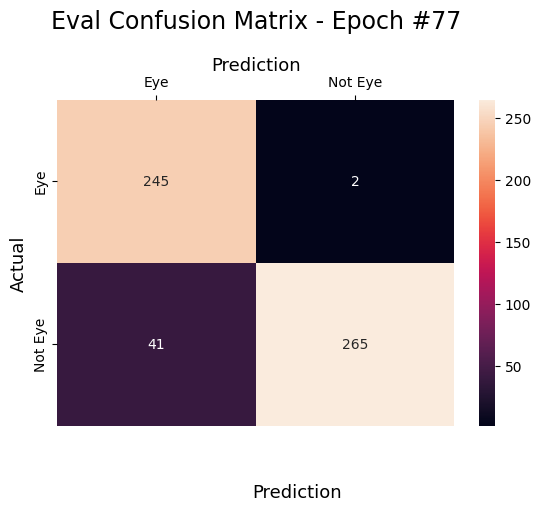

Epoch #78
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2338
           1       0.98      0.93      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       247
           1       0.99      0.92      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



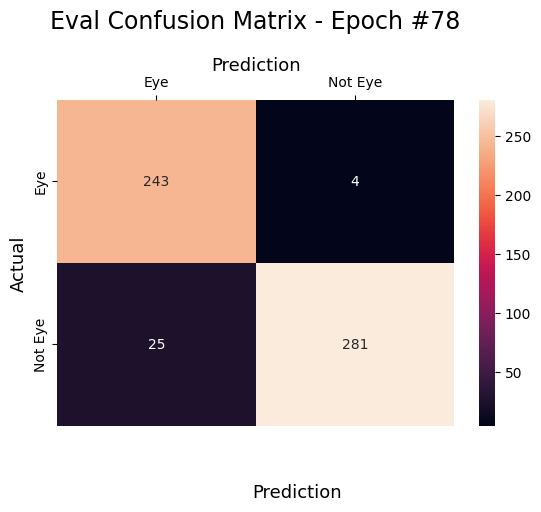

Epoch #79
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       247
           1       0.99      0.92      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



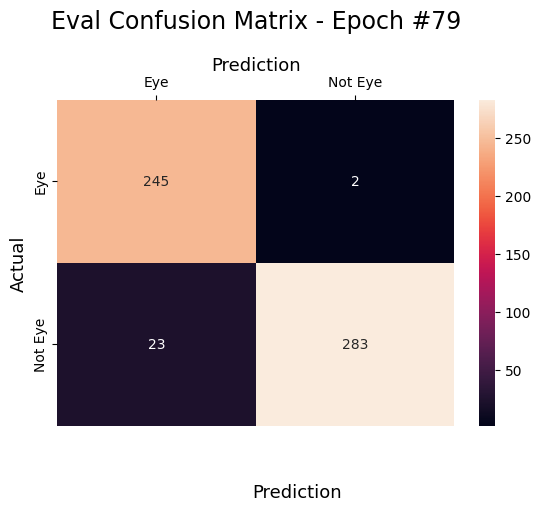

Epoch #80
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.98      0.86      0.91       306

    accuracy                           0.91       553
   macro avg       0.91      0.92      0.91       553
weighted avg       0.92      0.91      0.91       553



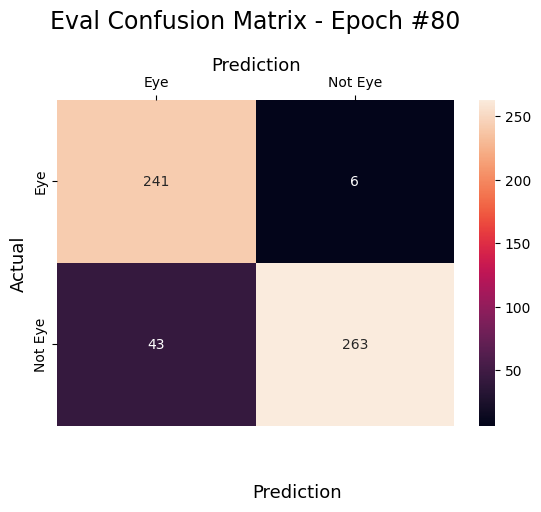

Epoch #81
Training: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2338
           1       0.98      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       247
           1       0.99      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



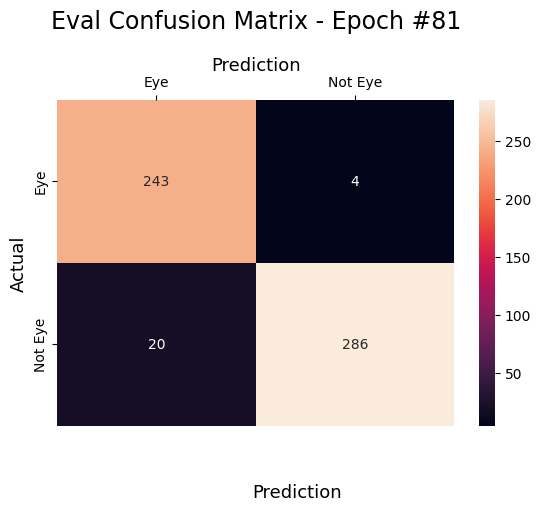

Epoch #82
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2338
           1       0.98      0.95      0.97      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       247
           1       0.98      0.94      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



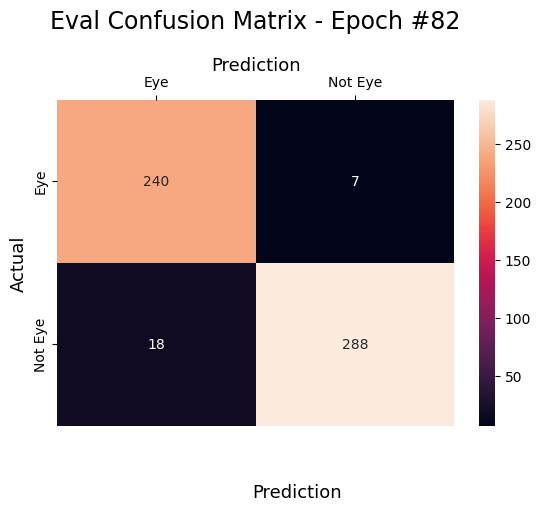

Epoch #83
Training: 
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2338
           1       0.97      0.92      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       247
           1       0.98      0.93      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



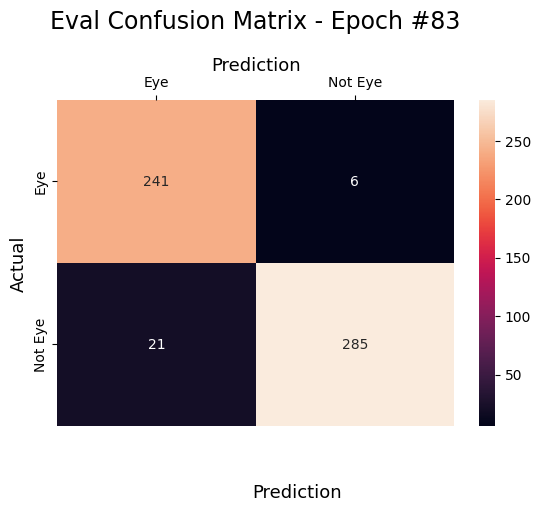

Epoch #84
Training: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2338
           1       0.97      0.95      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       247
           1       0.95      0.96      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



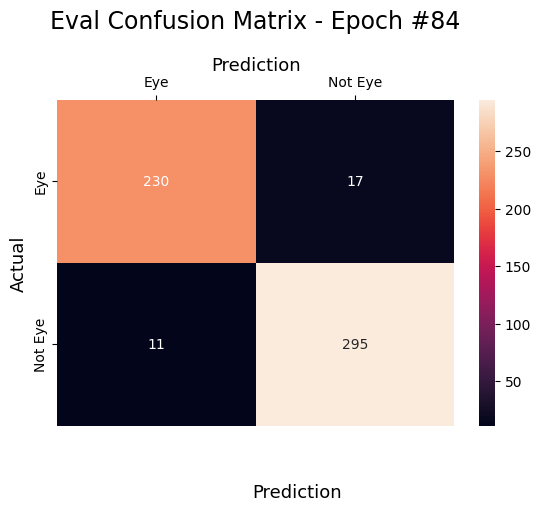

Epoch #85
Training: 
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2338
           1       0.98      0.85      0.91      2635

    accuracy                           0.91      4973
   macro avg       0.92      0.92      0.91      4973
weighted avg       0.92      0.91      0.91      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       1.00      0.85      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.91       553
weighted avg       0.93      0.92      0.92       553



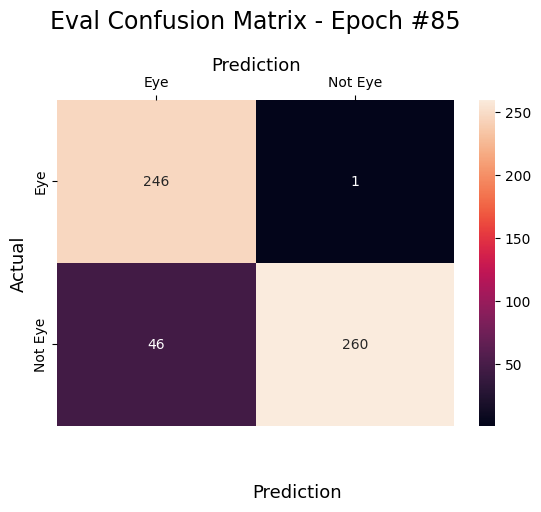

Epoch #86
Training: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2338
           1       0.98      0.93      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       247
           1       0.99      0.91      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.95      0.94      0.94       553



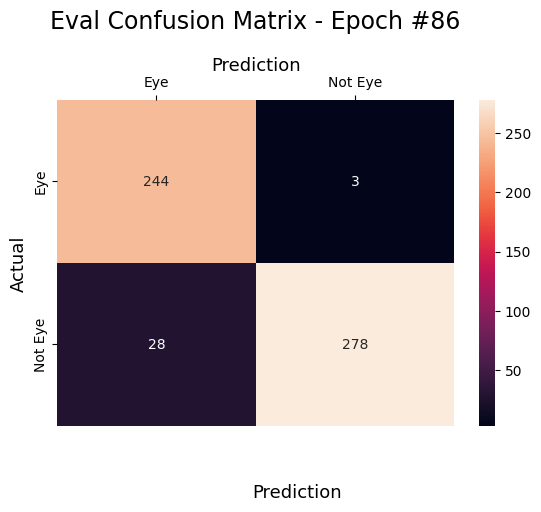

Epoch #87
Training: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2338
           1       0.98      0.93      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.96      0.95      4973
weighted avg       0.96      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       247
           1       0.98      0.96      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



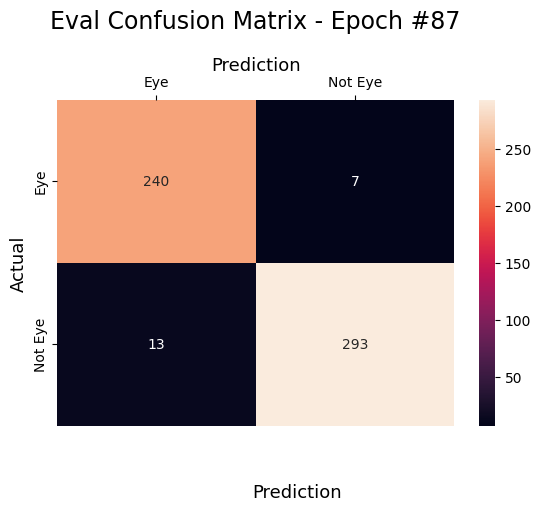

Epoch #88
Training: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2338
           1       0.98      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.94      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       247
           1       1.00      0.77      0.87       306

    accuracy                           0.87       553
   macro avg       0.89      0.88      0.87       553
weighted avg       0.90      0.87      0.87       553



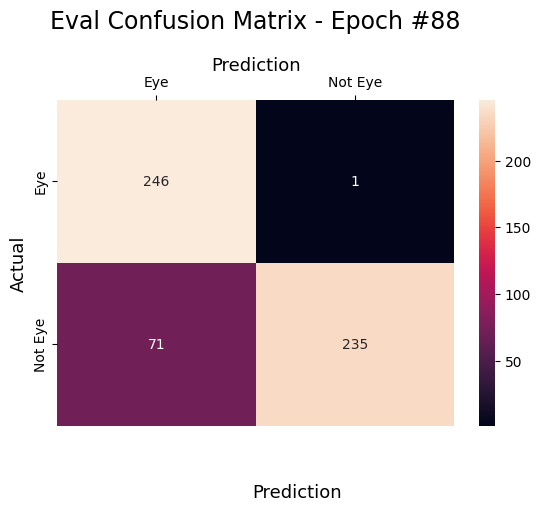

Epoch #89
Training: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2338
           1       0.99      0.87      0.93      2635

    accuracy                           0.93      4973
   macro avg       0.93      0.93      0.93      4973
weighted avg       0.93      0.93      0.93      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       247
           1       1.00      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.96      0.96      0.96       553



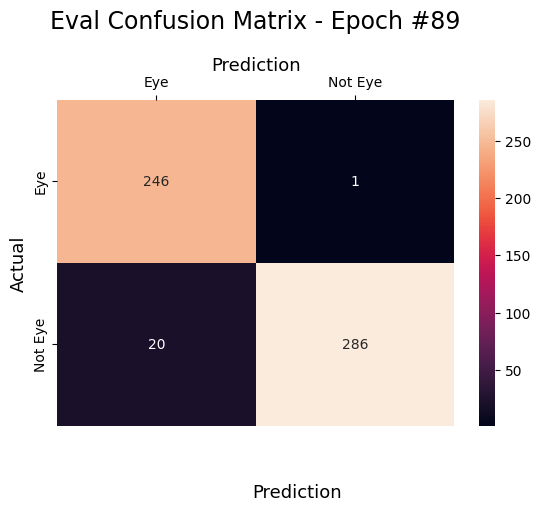

Epoch #90
Training: 
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2338
           1       0.98      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       247
           1       1.00      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



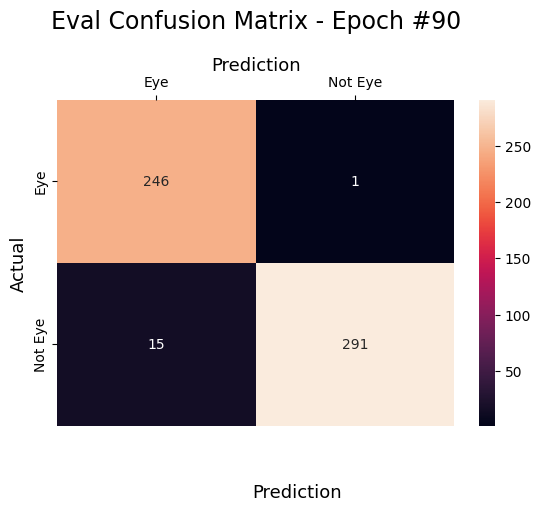

Epoch #91
Training: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2338
           1       0.99      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.95      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       247
           1       1.00      0.94      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.97      0.96      0.96       553



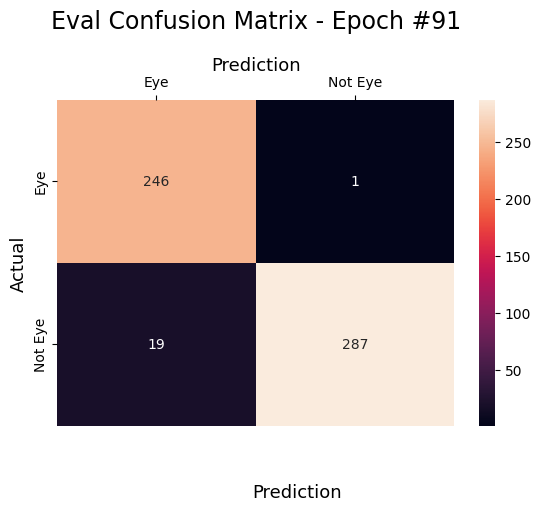

Epoch #92
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.92      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       247
           1       1.00      0.91      0.95       306

    accuracy                           0.95       553
   macro avg       0.95      0.95      0.95       553
weighted avg       0.95      0.95      0.95       553



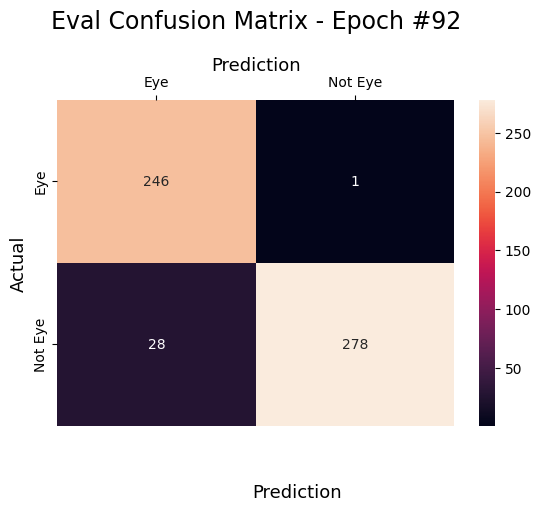

Epoch #93
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       247
           1       0.99      0.94      0.97       306

    accuracy                           0.97       553
   macro avg       0.96      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



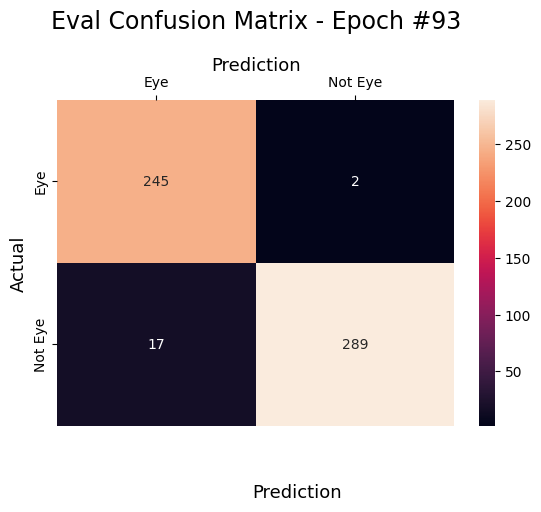

Epoch #94
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.97      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.97      0.96      4973
weighted avg       0.97      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.97      0.96      0.96       553



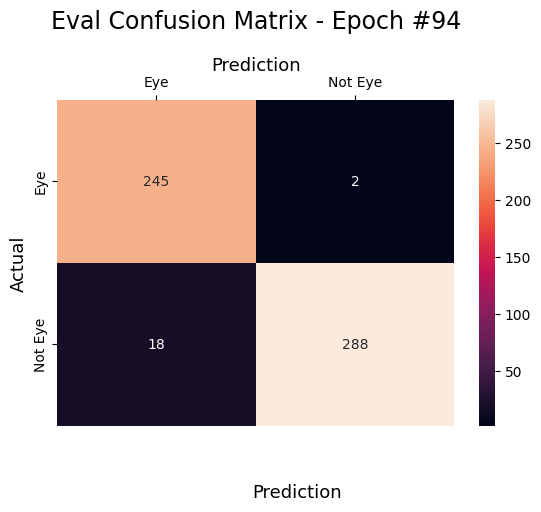

Epoch #95
Training: 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2338
           1       0.99      0.87      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.93      0.93      0.92      4973
weighted avg       0.93      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       1.00      0.85      0.92       306

    accuracy                           0.92       553
   macro avg       0.92      0.92      0.91       553
weighted avg       0.93      0.92      0.92       553



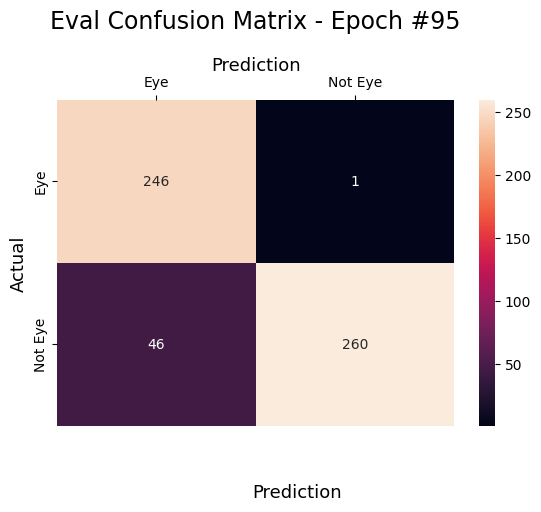

Epoch #96
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       247
           1       0.99      0.90      0.94       306

    accuracy                           0.94       553
   macro avg       0.94      0.94      0.94       553
weighted avg       0.94      0.94      0.94       553



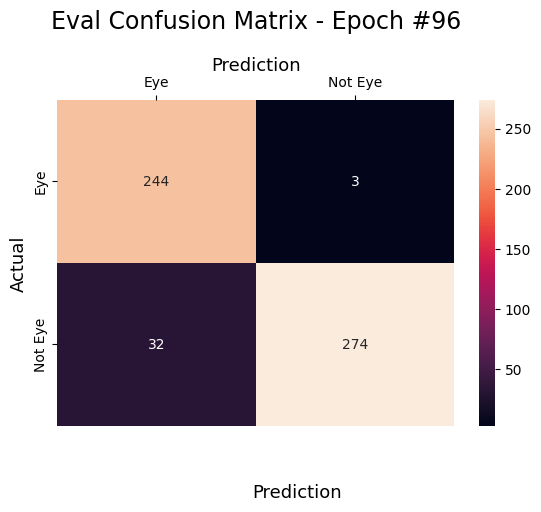

Epoch #97
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.96      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



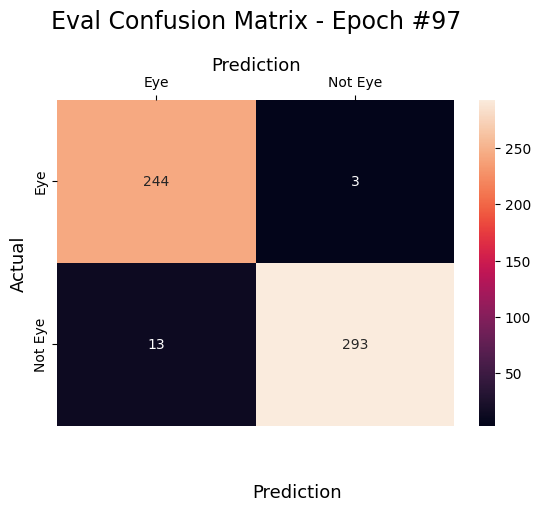

Epoch #98
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       247
           1       0.99      0.96      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



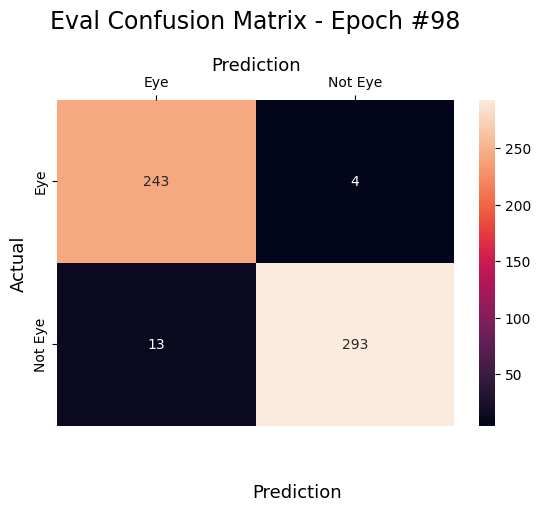

Epoch #99
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.97      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.97      0.96      4973
weighted avg       0.97      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       247
           1       0.98      0.95      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



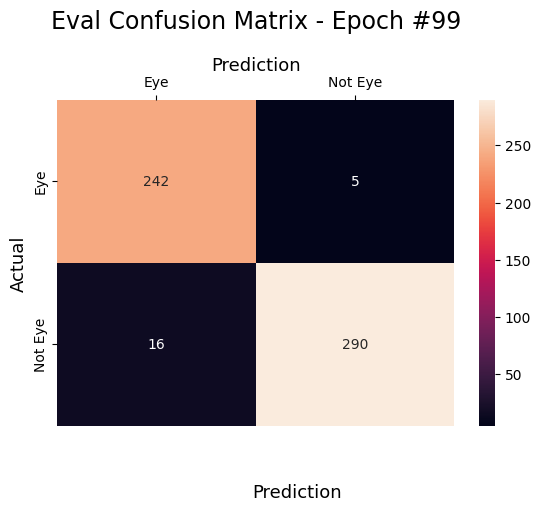

Epoch #100
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       247
           1       1.00      0.92      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



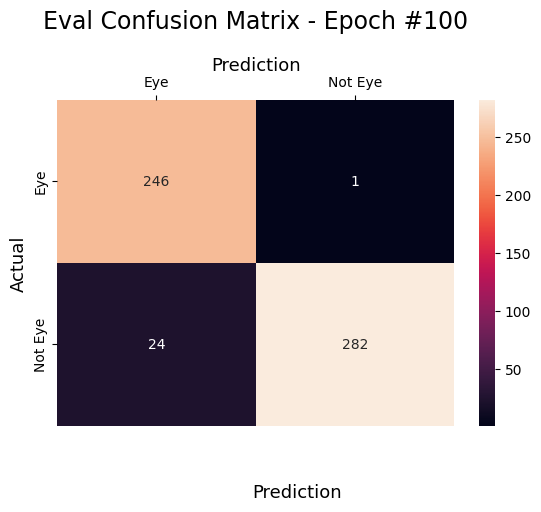

Epoch #101
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2338
           1       0.99      0.92      0.96      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.96      0.95      4973
weighted avg       0.96      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



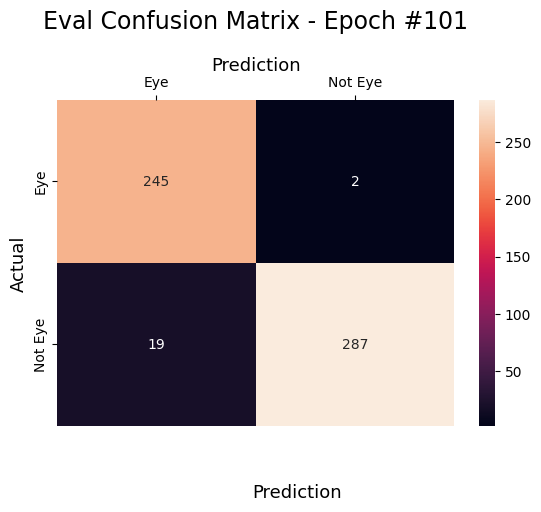

Epoch #102
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       247
           1       0.99      0.97      0.98       306

    accuracy                           0.98       553
   macro avg       0.98      0.98      0.98       553
weighted avg       0.98      0.98      0.98       553



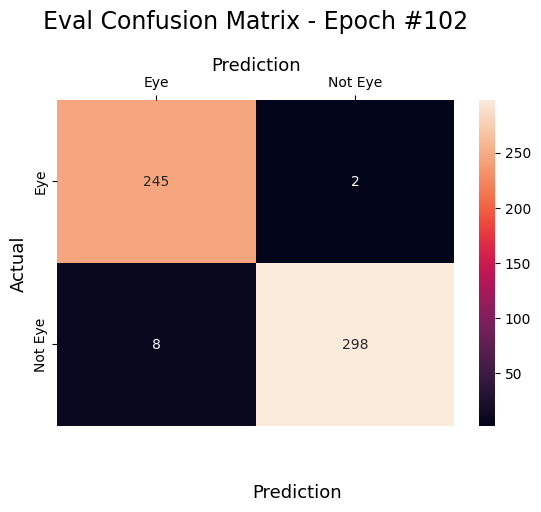

Epoch #103
Training: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2338
           1       0.98      0.95      0.97      2635

    accuracy                           0.97      4973
   macro avg       0.97      0.97      0.97      4973
weighted avg       0.97      0.97      0.97      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



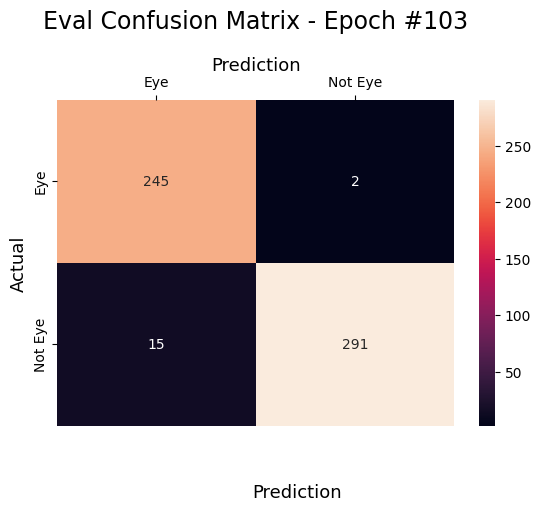

Epoch #104
Training: 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2338
           1       0.99      0.91      0.95      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.95      0.95      4973
weighted avg       0.95      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       247
           1       1.00      0.86      0.92       306

    accuracy                           0.92       553
   macro avg       0.93      0.93      0.92       553
weighted avg       0.93      0.92      0.92       553



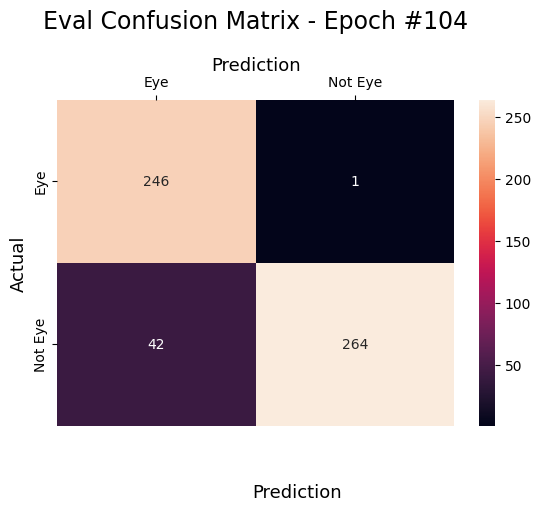

Epoch #105
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



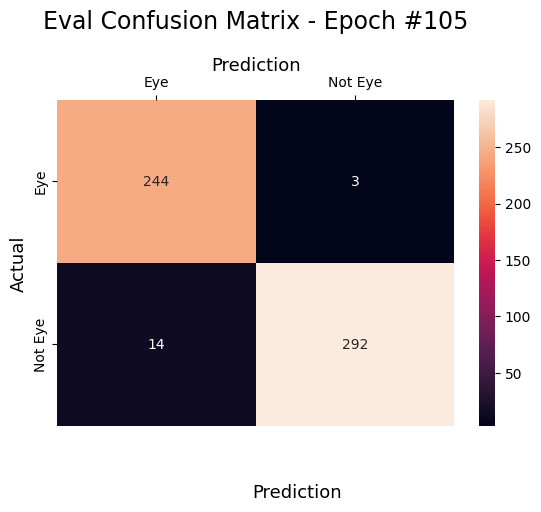

Epoch #106
Training: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2338
           1       0.99      0.95      0.97      2635

    accuracy                           0.97      4973
   macro avg       0.97      0.97      0.97      4973
weighted avg       0.97      0.97      0.97      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



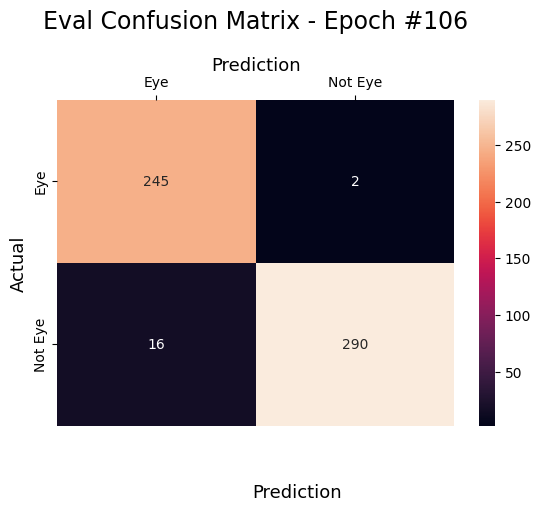

Epoch #107
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       247
           1       1.00      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.96      0.96      0.96       553



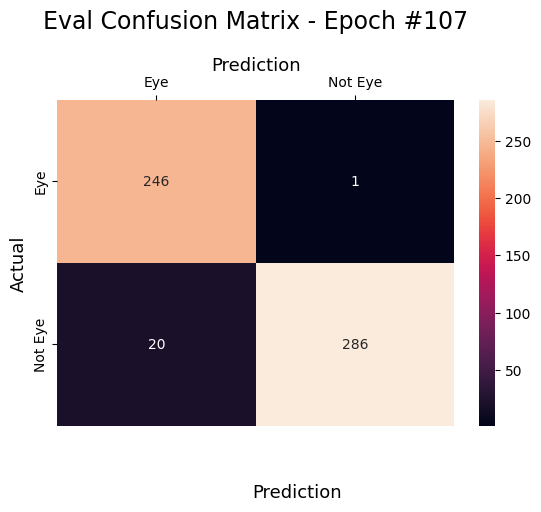

Epoch #108
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



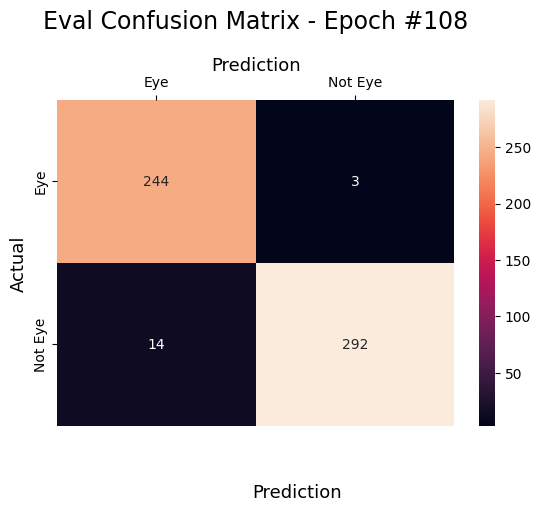

Epoch #109
Training: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2338
           1       0.99      0.96      0.97      2635

    accuracy                           0.97      4973
   macro avg       0.97      0.97      0.97      4973
weighted avg       0.97      0.97      0.97      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       247
           1       0.99      0.94      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



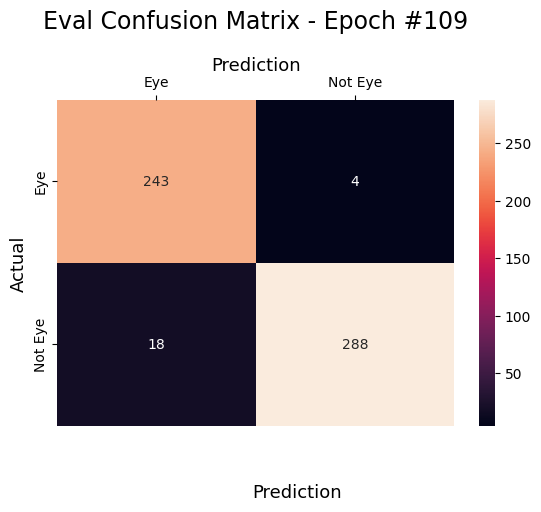

Epoch #110
Training: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.96      2338
           1       0.99      0.95      0.97      2635

    accuracy                           0.97      4973
   macro avg       0.97      0.97      0.97      4973
weighted avg       0.97      0.97      0.97      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.96      0.98       306

    accuracy                           0.97       553
   macro avg       0.97      0.98      0.97       553
weighted avg       0.98      0.97      0.97       553



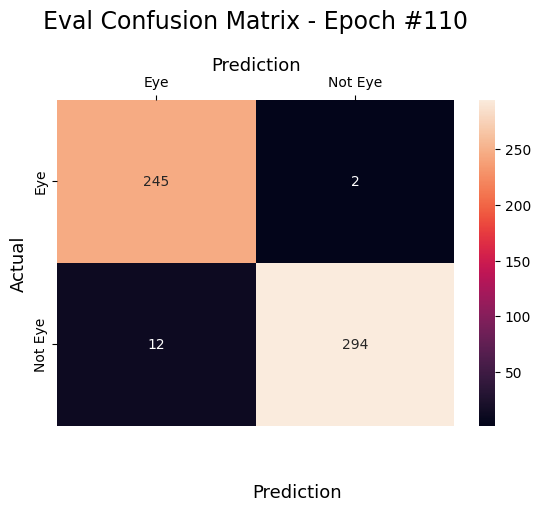

Epoch #111
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



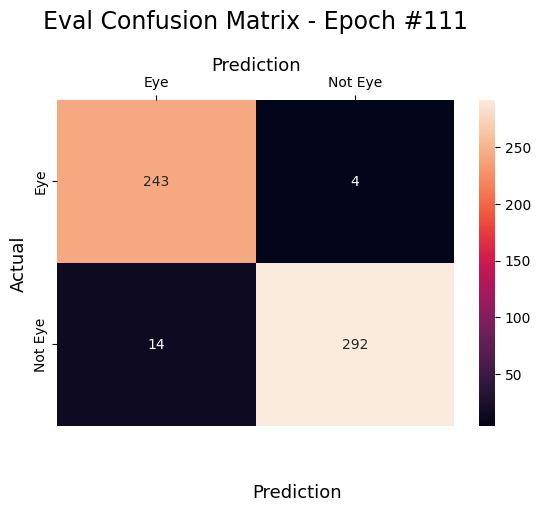

Epoch #112
Training: 
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2338
           1       0.98      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.95      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       247
           1       0.98      0.96      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



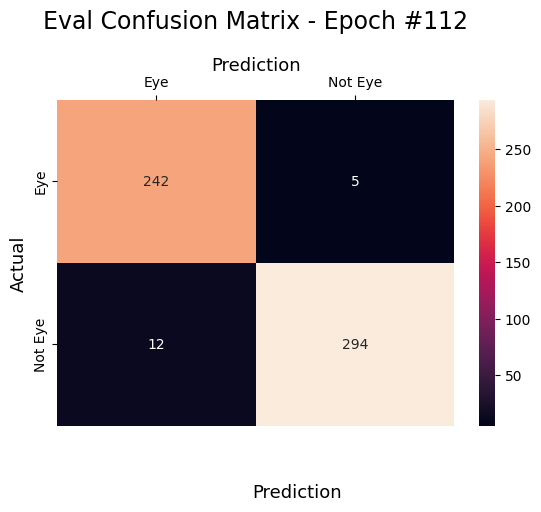

Epoch #113
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.97      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.97      0.96      4973
weighted avg       0.97      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       247
           1       1.00      0.92      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



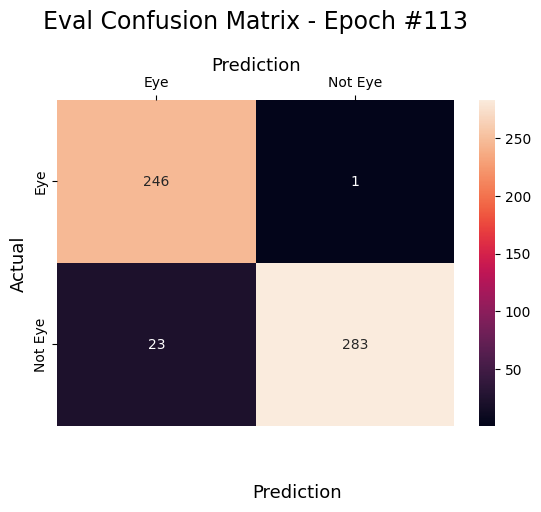

Epoch #114
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2338
           1       0.99      0.92      0.96      2635

    accuracy                           0.95      4973
   macro avg       0.96      0.96      0.95      4973
weighted avg       0.96      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       247
           1       1.00      0.90      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.95      0.94      0.94       553



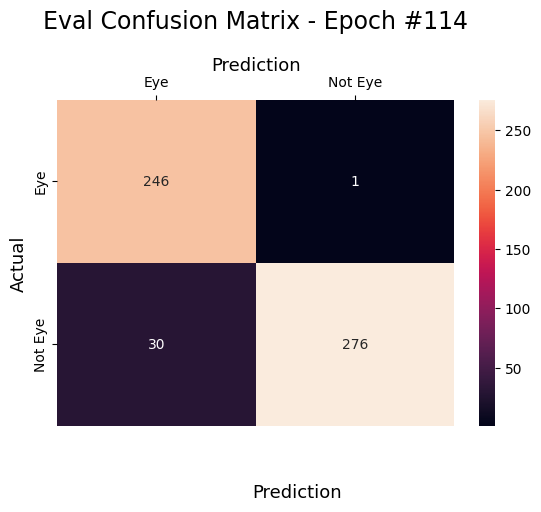

Epoch #115
Training: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2338
           1       0.99      0.92      0.96      2635

    accuracy                           0.95      4973
   macro avg       0.95      0.96      0.95      4973
weighted avg       0.96      0.95      0.95      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       247
           1       1.00      0.92      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



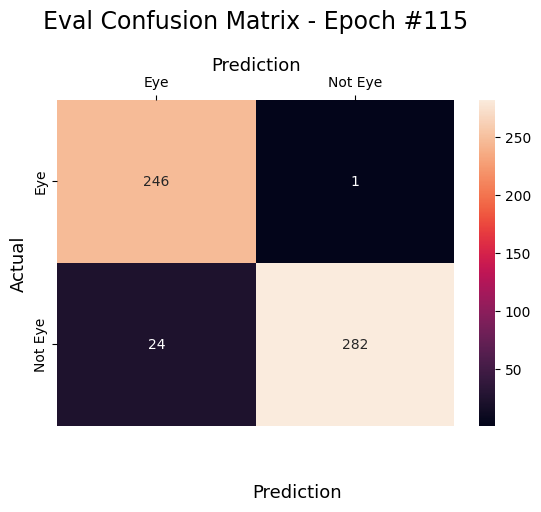

Epoch #116
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       247
           1       0.99      0.94      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



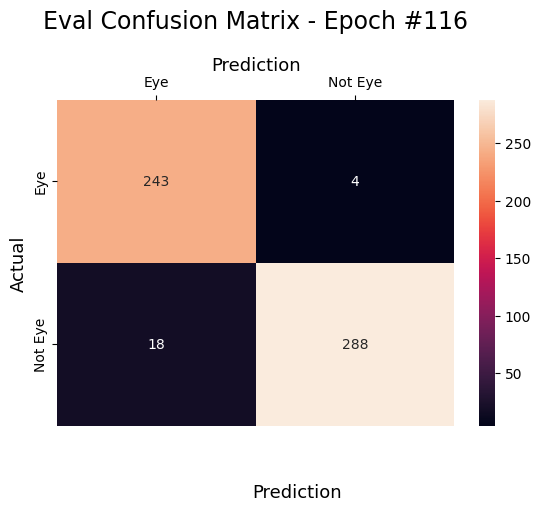

Epoch #117
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2338
           1       0.99      0.95      0.97      2635

    accuracy                           0.97      4973
   macro avg       0.97      0.97      0.97      4973
weighted avg       0.97      0.97      0.97      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       247
           1       1.00      0.93      0.96       306

    accuracy                           0.96       553
   macro avg       0.96      0.96      0.96       553
weighted avg       0.96      0.96      0.96       553



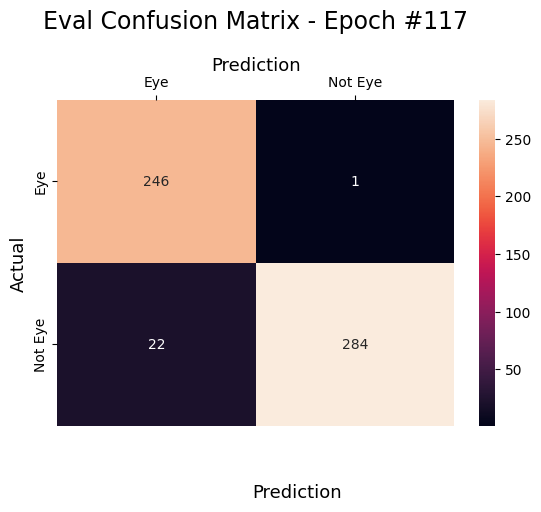

Epoch #118
Training: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       247
           1       1.00      0.90      0.95       306

    accuracy                           0.94       553
   macro avg       0.94      0.95      0.94       553
weighted avg       0.95      0.94      0.94       553



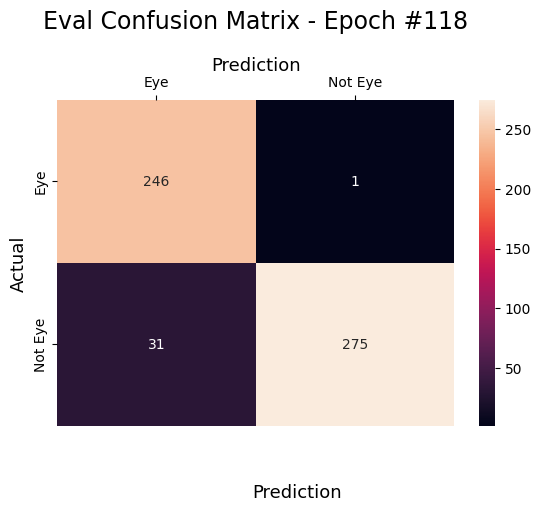

Epoch #119
Training: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2338
           1       0.99      0.90      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.97      0.96      0.96       553



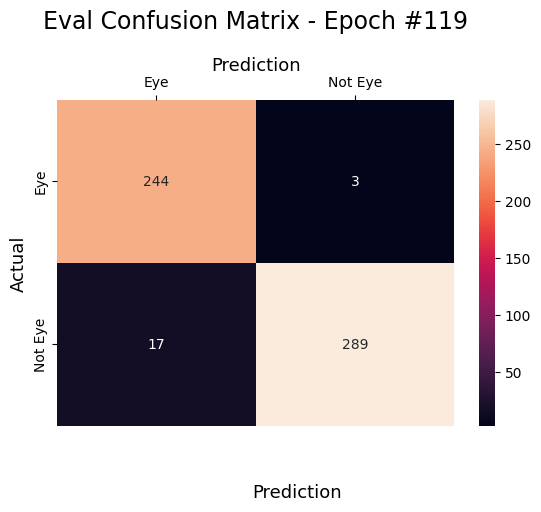

Epoch #120
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       247
           1       0.99      0.95      0.97       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



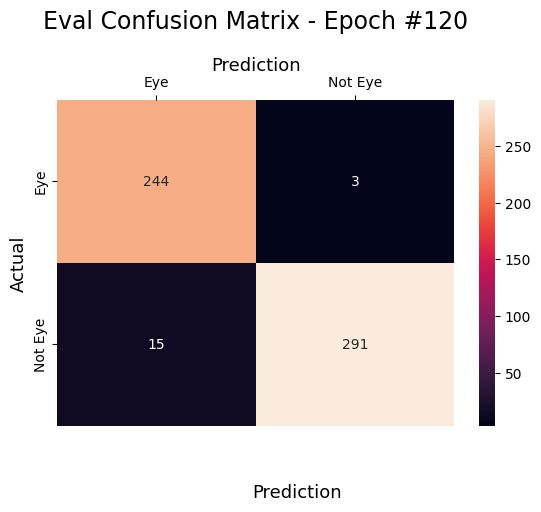

Epoch #121
Training: 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      2338
           1       0.99      0.85      0.92      2635

    accuracy                           0.92      4973
   macro avg       0.92      0.92      0.92      4973
weighted avg       0.93      0.92      0.92      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       247
           1       1.00      0.83      0.91       306

    accuracy                           0.90       553
   macro avg       0.91      0.91      0.90       553
weighted avg       0.92      0.90      0.90       553



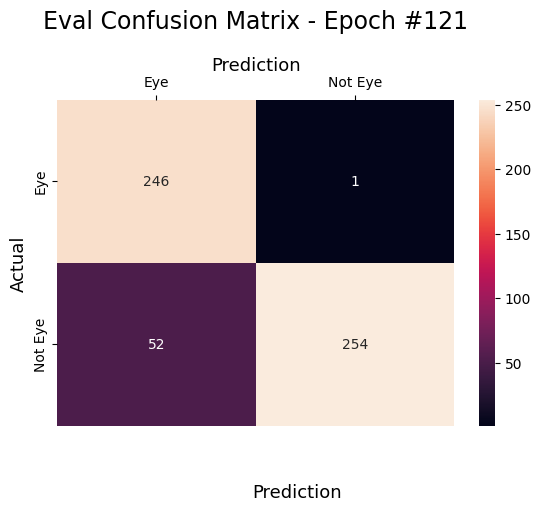

Epoch #122
Training: 
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2338
           1       0.99      0.89      0.94      2635

    accuracy                           0.94      4973
   macro avg       0.94      0.94      0.94      4973
weighted avg       0.95      0.94      0.94      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       247
           1       0.99      0.94      0.97       306

    accuracy                           0.96       553
   macro avg       0.96      0.97      0.96       553
weighted avg       0.97      0.96      0.96       553



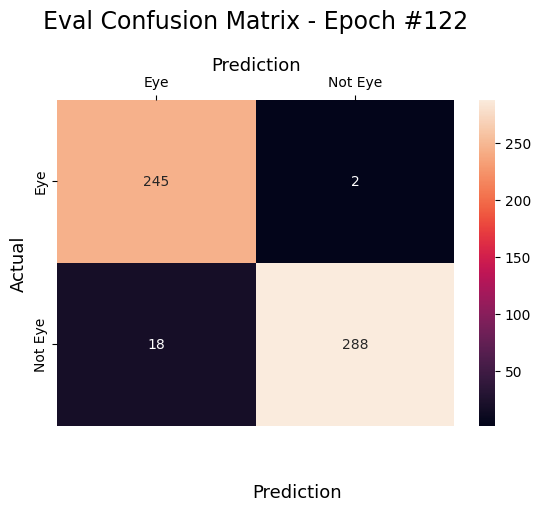

Epoch #123
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.94      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       247
           1       0.99      0.93      0.96       306

    accuracy                           0.95       553
   macro avg       0.95      0.96      0.95       553
weighted avg       0.96      0.95      0.95       553



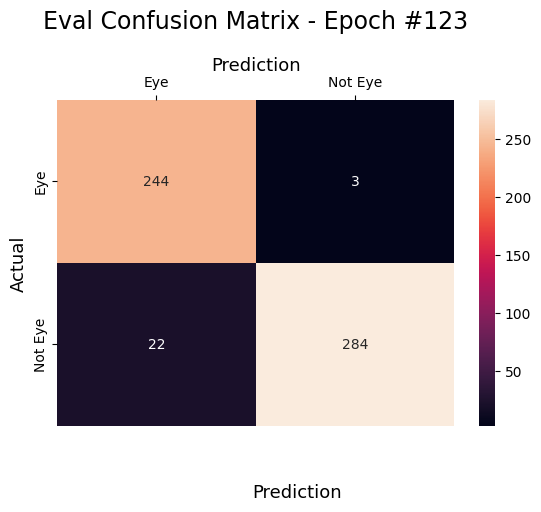

Epoch #124
Training: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2338
           1       0.98      0.95      0.97      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.97      0.96      4973
weighted avg       0.97      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       247
           1       0.98      0.98      0.98       306

    accuracy                           0.98       553
   macro avg       0.98      0.98      0.98       553
weighted avg       0.98      0.98      0.98       553



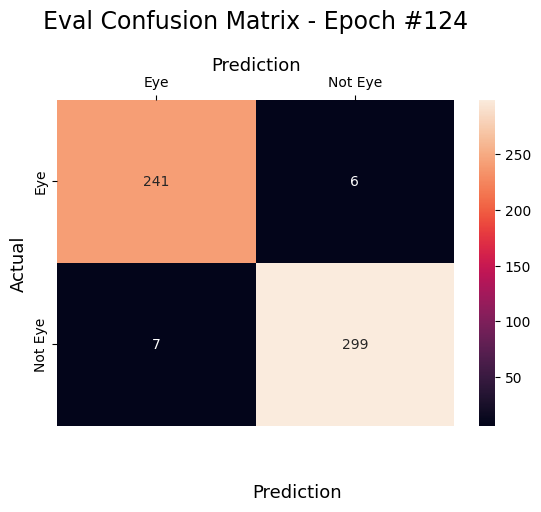

Epoch #125
Training: 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2338
           1       0.99      0.93      0.96      2635

    accuracy                           0.96      4973
   macro avg       0.96      0.96      0.96      4973
weighted avg       0.96      0.96      0.96      4973

Evaluation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.96      0.98       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



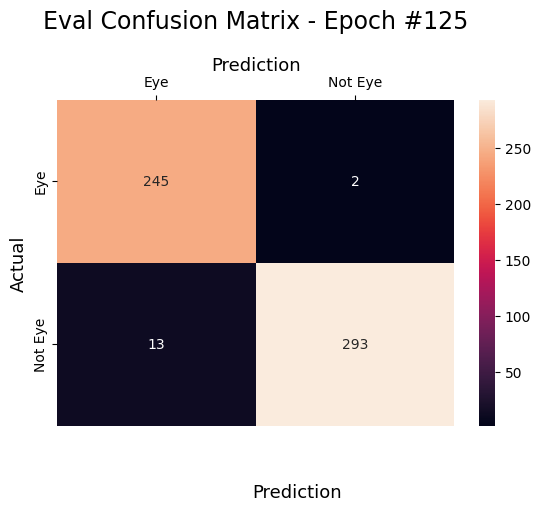

Eval/Accuracy,▅▁▅▆▅▅▇▇▅▆▇▇▇▇▆▇▇▆▆▇▇▅██▇▇█▇██▇██▇███▇██
Eval/F1-Score,▂▃▁▃▄▄▄▅▆▂▆▄▆▆▆▅▇▅▇▆▇▇▇▇▆▇▆▇▆▇▄▇█▇▇██▇██
Eval/Precision,▂▁▂▃▄▄▄▄▆▆▅▆▆▆▇▅▅▇▇▆▇▆█▇▆▇█▅█▇█▆████▇█▆█
Eval/Recall,▁▃▄▄▆▄▅▆▆▅▇▆▇▆▅▇▅▆▇▇▆▆▃▇▇▇▇▇▇▆█▇█▇█▇█▇▇█
Train/Accuracy,▁▃▄▄▅▆▅▆▇▆▇▇▇▆▇▇▇▇▇▇██▇▇▇▇▇█▇█▇██████▇▇█
Train/F1-Score,▁▁▂▃▃▄▄▄▆▅▆▆▆▆▇▆▇▇▆▇▇▇▇██▇▇▆▇▇▇▇███▇██▆█
Train/Precision,▁▃▃▃▃▆▆▅▅▅▆▆▅▆▆▇▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇████████
Train/Recall,▁▄▃▄▅▅▆▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇██▇█▇▇▇▇▇▇▇██████▇
Eval/Accuracy,0.97288
Eval/F1-Score,0.97267
Eval/Precision,0.97142


In [42]:
for i in range(num_epochs):
    
    epoch_message = f"Epoch #{i+1}"
    print(epoch_message)
    f.write(epoch_message + "\n")
    
    train_actual, train_predicted = model_train(model, optimizer, criterion, train_loader)
    eval_actual, eval_predicted = model_eval(model, test_loader)
    
    train_report = classification_report(train_actual, train_predicted, output_dict=True)
    train_report_message = "Training: \n" + str(classification_report(train_actual, train_predicted, zero_division=0))
    print(train_report_message)
    f.write(train_report_message + "\n")
    
    eval_report = classification_report(eval_actual, eval_predicted, output_dict=True)
    eval_report_message = "Evaluation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
    print(eval_report_message)
    f.write(eval_report_message + "\n")
    
    wandb.log({
        "Train/Precision": train_report["macro avg"]['precision'], 
        "Train/Recall": train_report["macro avg"]['recall'],
        "Train/F1-Score": train_report["macro avg"]['f1-score'],
        "Train/Accuracy": train_report["accuracy"],
        
        "Eval/Precision": eval_report["macro avg"]['precision'], 
        "Eval/Recall": eval_report["macro avg"]['recall'],
        "Eval/F1-Score": eval_report["macro avg"]['f1-score'],
        "Eval/Accuracy": eval_report["accuracy"]
    })
    
    create_confusion_matrix(eval_actual, eval_predicted, i)
    
    

wandb.finish()   


Validation: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       247
           1       0.99      0.96      0.98       306

    accuracy                           0.97       553
   macro avg       0.97      0.97      0.97       553
weighted avg       0.97      0.97      0.97       553



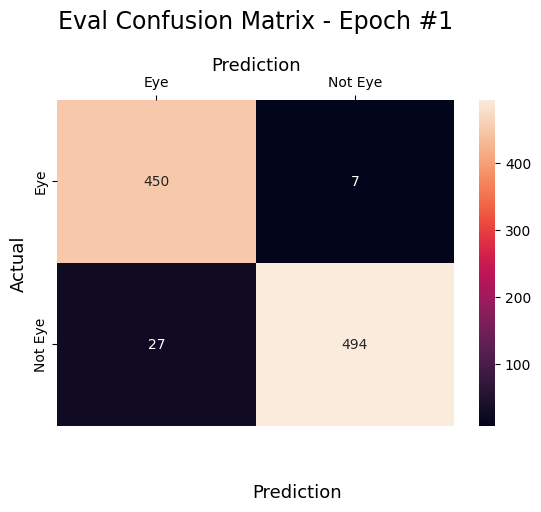

In [43]:
validation_actual, validation_predicted = model_eval(model, val_loader)

validation_report = classification_report(validation_actual, validation_predicted, output_dict=True)
validation_report_message = "Validation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
f.write(validation_report_message + "\n")
print(validation_report_message)
    
create_confusion_matrix(validation_actual, validation_predicted, 0)
f.close() 

In [44]:
torch.save(model.state_dict(), "../info/models/validation/" + model_name + ".pth")